# Project 4
Wayne Mitchell

## Import modules

In [851]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import os
import inspect
import sdv
from sdv.metadata import Metadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import TVAESynthesizer
from sdv.single_table import CopulaGANSynthesizer
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import get_column_plot
import re
import math
import inspect

### NOTES:
- observed that the synthetic data synthesizers did not handle the<br>
one-hot refactoring of 'genres': all values the one-hot category columns <br>
are set to  zero in the synthetic data.<br>
This is probably because a single positive value in one cell of a long column of zeros<br>
is so infrequent that the 'one' also looks like a 'zero', statistically speaking. Work arround: <br>
first altered the genre cateories from embedded lists to concatenated stings; then,<br>
generated synthetic data useing genre categories; then combined with real data;<br>
then 'deconcatenated' to restore original format; then split sub-lists<br>
and only then did one-hot encoding<br>


## Functions:
1. calculate unpopularity threshold(df, method)
2. transform_neg_column_values_to_pos(df, column_names)
3. get_var_name(var)
4. test_lists_for_identity(list_of_lists)
5. make_backup_dict_of_columns(df, key_column, value_column)
6. remove_nulls_if_less_than_threshhold(df, percent)
7. count_duplicates()
8. remove_duplicates(df, columns_to_check):
9. convert_column_to_index(df, column_to_convert)
10. remove_columns(df, columns_to_remove):
11. change_sublist_to_concatenated_string(df, new_col_name)
12. one_hot_encode_genres(df, target_column, genre_retain_threshold)
13. create_and_save_metadata(unpopular_songs_df, file_path, tablename)
14. create_synthetic_data(df, metadata, synthesizer_engine, target_sample_number)
15. save_synthetic_data_to_file(data, filepath)
16. check_real_versus_synthetic_column_names(real_df, syth_df)
17. plot_real_versus_synth_data(column_name, real_data_df, synth_data_df, metadata)
18. add_column_to_dataframe_and_fill_with_a_value(df, column_name, value)
19. stack_merge_dataframes(df_list)
20. unconcatenate_dataframe_column(df)
21. make_and_run_RandomForestModel(merged_restored_df, y_column_name, random_state, n_estimators)


In [855]:
# Function 1
def calculate_unpopularity_threshold(df, method):
    df_stats = df.describe()
    if method == 'three_std':
        mean = df_stats.at['mean','track_popularity']
        std = df_stats.at['std','track_popularity']
        threshold = mean - (3 * std)
        threshold = int(math.ceil(threshold))
        return threshold
    elif method == 'lower_quartile':
        threshold = df_stats.at['25%','track_popularity']
        threshold = int(math.ceil(threshold))
        return threshold

In [856]:
# Function 2
def transform_neg_column_values_to_pos(df, column_names):
    for col_name in column_names:
        print(col_name)
        max_col_value = max(df[col_name])
        min_col_value = min(df[col_name])
        delta = max_col_value - min_col_value
        new_col_name = 'transformed_' + col_name 
        df[new_col_name] = df[col_name].transform(lambda x: x + delta)
        df = df.drop(columns=[col_name])
    return df

In [857]:
# Function 3
def get_var_name(var):
    current_frame = inspect.currentframe()
    caller_frame = inspect.getouterframes(current_frame)[1]
    local_vars = caller_frame.frame.f_locals

    for name, value in local_vars.items():
        if value is var:
            return name

In [858]:
# Function 4
def test_lists_for_identity(list_of_lists):
    
    list_report_dict={}
    
    list_length = (len(list_of_lists))-1
    for i in range(list_length):
        for j in range(list_length):
            if (i < j):
                this_key = 'list_' + str(i) + '_to_' + 'list_' + str(j) 
                if list_of_lists[i] == list_of_lists[j]:
                    list_report_dict.update({this_key: 'equivilent'})
                else:
                    list_report_dict.update({this_key: 'NOT equivilent'})

    return list_report_dict

In [859]:
# Function 5
def make_backup_dict_of_columns(df, key_column, value_column):
    keys = list(df[key_column])
    values = list(df[value_column])
    zipper = zip(keys, values)
    this_dict = dict(zipper)
    return this_dict

In [860]:
# Function 6
def remove_nulls_if_less_than_threshhold(df, threshold):
    # count nulls
    null_count = df.isnull().sum()

    #count rows
    row_count = df.shape[0]

    if null_count <= threshold * row_count:
        #remove rows with null
        df.dropna(inplace=True)
        return df
    else:
        return False

In [861]:
# Function 7
def count_duplicates_in_column(df, column):
    # Count occurrences of each value in the column
    value_counts = df[column].value_counts()

    # Identify and count duplicates
    duplicates = value_counts[value_counts > 1]
    num_duplicates = duplicates.sum() - len(duplicates)

    return num_duplicates

In [862]:
# Function 8
def remove_duplicates(df, column_to_check):
    # keep the first occurance
    df = df.drop_duplicates(subset=[column_to_check], keep='first')
    return df

In [863]:
# Function 9
def remove_columns(df, columns_to_remove):
    df = df.drop(columns=columns_to_remove)
    return df

In [864]:
# Function 10
def convert_column_to_index(df, column_to_convert):
    df.set_index(column_to_convert, inplace=True)
    return df

In [865]:
# Function 11
def convert_index_to_column(df, new_column_name):
    df = df.reset_index().rename(columns={'index': new_column_name})
    return df

In [866]:
# Function 12
def change_sublist_to_concatenated_string(df, target_column, new_col):

    pattern = r"[\'\(\)\[\]\{\}]"
    pattern_2 = r", "
    pattern_3 = r" "
    errors = []
    i = 0
    for sublist in df[target_column]:
        sublist = re.sub(pattern,"",sublist)
        sublist = sublist.strip()
        sublist = re.sub(pattern_2,"_",sublist)
        sublist = re.sub(pattern_3,"+",sublist)
        df.at[i,new_col] = sublist
        if  ( re.findall(pattern_3, sublist) or re.findall(pattern_2, sublist)  ):
            errors.append(sublist)
        i+=1
 
    # remove old column
    df = df.drop(columns=[target_column])
    if len(errors) == 0:
        return df
    else:
        return False

In [867]:
# Function 13
def one_hot_encode_genres(df, target_column, genre_retain_threshold):

    # get row count
    row_count = df.shape[0]
    print(f"row_count: {row_count}")
    # fill empty cells to force 'other' assignment
    df[target_column]= df[target_column].fillna('X')

    # explode sublists and get list of unique genres
    all_genres_list = []
    pattern = r"[\'\(\)\[\]\{\}]"
    pattern_2=r" "
    for genre_sublist in df[target_column]:
        for genre in genre_sublist: 
            genre = re.sub(pattern_2,"_",genre)
            #####print(genre)
            all_genres_list.append(genre)

    print(f"all_genres_list: {len(all_genres_list)}")
    print(all_genres_list[0:5])
    #['hip_hop', 'rap', 'alt_z',
    
    # get genre list for frequency at least equal to threshold
    ## make a df from list of all genres
    ## use value_counts to get count of uniques

    genres_df = pd.DataFrame(all_genres_list, columns=['all_genres'])
    genre_counts = genres_df['all_genres'].value_counts(sort=True)
    unique_genre_keepers = []
    for index, value in genre_counts.items():
        if value >= genre_retain_threshold:
            unique_genre_keepers.append(index)
                                    ####print(f"unique_genre_keepers: {len(unique_genre_keepers)}")
                                    ####print(unique_genre_keepers)
    print(f"length unique_genre_keepers: {unique_genre_keepers}")
    print(unique_genre_keepers[0:5])
    ### get uniques genres 
    ### (should already be unique, from value_count step, but just in case ...)
    #unique_genre_keepers_2 = list(dict.fromkeys(unique_genre_keepers))
    #unique_genre_keepers_2.sort()

    # add columns for one-hot categories and populate with all zeros
    
    #for this_unique_genre in unique_genre_keepers:
    #    insert_column_name = 'genre_' + this_unique_genre
     #   col_names_for_insert.append(insert_column_name)
        #df[column_name] = [0] * len(df)
        #df[this_genre] = np.zeros(len(df),dtype=int)
    # add the 'other' one-hot category column; populate with zeros
    #df['genre_other'] = [0] * len(df)

    # insert columns with concat
    
    col_names_for_insert = unique_genre_keepers
    col_names_for_insert.append('genre_other')

    print(f"col_names_for_insert length: {len(col_names_for_insert)}")
    print(col_names_for_insert[0:5])

    new_columns_dict = {}
    all_zeros = []
    
    for i in range(len(df)):
        all_zeros.append(0)
        
    for col_name in col_names_for_insert:
        new_columns_dict[col_name] = all_zeros

    new_cols_df = pd.DataFrame(new_columns_dict)
    df = pd.concat([df, new_cols_df], axis=1)
    
    # iterate through 'target column' values/ sublist values (genres);
    # if genre from df row found in unique_genres_keepers, set the
    # corresponding one-hot category cell to '1', otherwise set 'other' cell to '1'
    named_genre = 0
    other_genre = 0
    pattern = r"[\'\(\)\[\]\{\}]"
    pattern_2=r" "
    i = 0
    for genre_sublist in df[target_column]:
        for genre in genre_sublist: 
                                    #for gen in df[target_column]:
                                    #### split sublist into list
                                    ####genre_list  = gen.split(",")
                                        ###named_genre_found = True
                                   ##### for genre in genre_list: 
            genre = re.sub(pattern,"",genre)
            genre = genre.strip()
            genre = re.sub(pattern_2,"_",genre)
            #print(f"genre for test against keepers: {genre}")
            if genre in unique_genre_keepers:
                #print(f"genre for test against keepers: {genre}")
                df.at[i,genre] = 1
                named_genre += 1
        else:
            df.at[i,'genre_other'] = 1
            other_genre += 1
            
        i += 1


            
    # drop target column
    df.drop(columns=[target_column])
    return df
    #print("finaal dataframe head")
    #df.head()
    #return the modified df if eery row was  parsed into a one-hot category column
    # else return 'False'
    #if (named_genre + other_genre) == len(df):
    #    print("returning df")
    #    return df
    #else:
    #    print("not returning df")
    #    return False

In [868]:
#merged_restored_onehot_df = merged_restored_df.copy()
#merged_restored_onehot_df.head()

In [869]:
#merged_restored_onehot_df = convert_index_to_column(merged_restored_onehot_df, 'track_id')
#merged_restored_onehot_df = one_hot_encode_genres(merged_restored_onehot_df, 'artist_genres', 8)
#merged_restored_onehot_df.head()

In [870]:
#merged_restored_onehot_df.shape


In [871]:
#cnts = merged_restored_onehot_df['latin_hip_hop'].value_counts()
#print(cnts)

In [872]:
#target_column = 'artist_genres'
#genre_retain_threshold = 15
#testcase_df = one_hot_encode_genres(merged_restored_df, target_column, genre_retain_threshold)
#testcase_df.head()

In [891]:
# Function 14
def  create_and_save_metadata(df, this_filepath, this_tablename):
    
    # create metadata
    metadata = Metadata.detect_from_dataframe(
        data=df,
        table_name=this_tablename
    )
    
    # save metadata to json file
    metadata.save_to_json(this_filepath)
    
    return metadata

In [892]:
# Function 15
def create_synthetic_data(df, metadata, synthesizer_engine, target_sample_number):

    # Create a synthesizer model
    synthesizer_model = synthesizer_engine(metadata)

    # Fit the synthesizer to the real data
    synthesizer_model.fit(df)

    # Generate synthetic data (e.g., 1000 samples)
    synthetic_data_df = synthesizer_model.sample(num_rows=target_sample_number)

    return synthetic_data_df

In [895]:
# Function 16
def check_real_versus_synthetic_column_names(real_df, syth_df):
   
    # get list of column names from real_data frame
    column_names_real = real_df.columns
    # get list of column names from synthetic data_frame
    column_names_synth = syth_df.columns

    # sort the column name lists
    column_names_real_sorted = sorted(column_names_real)
    column_names_synth_sorted = sorted(column_names_synth)

    if column_names_real_sorted == column_names_synth_sorted:
        return True
    else:
        return False

In [896]:
# Function 17
def plot_real_versus_synth_data(real_data_df, synth_data_df, metadata):
    # get list of column names from real_data frame
    column_names = real_data_df.columns
    # get list of column names from synthetic data_frame
    fig = get_column_plot(
        real_data=real_data_df,
        synthetic_data=synth_data_df,
        metadata=metadata,
        column_name=column_names
    )
    return fig   

In [897]:
# Function 18
def add_column_to_dataframe_and_fill_with_a_value(df, column_name, value):
    df[column_name] = [value] * len(df)
    return(df)

In [898]:
# Function 19
def stack_merge_dataframes(df_list):

    df1 = df_list.pop()
    print(type(df1))
    df2 = df_list.pop()
    print(type(df2))
    df_stacked = pd.concat([df1, df2])

    for i in range(len(df_list)):
        df = df_list[i]
        print(type(df))
        df_stacked = pd.concat([df_stacked, df])

    return df_stacked

In [899]:
# Function 20
def unconcatenate_dataframe_column(df, column_name, new_column_name):
    #get target column as list
    
        #####print(f"nuls count: {df.isnull().sum()}")
    column_list = df[column_name].tolist()
        #### print(f"type: {type(column_list)}")
    # iterate through list and split concatented string into tmp_list of strings
    delimiter = " "
    new_col_values = []
    for element in column_list:
            #####print(f"element: {element}, type: {type(element)}")
        tmp_list = element.split('_')
        temp_new_list = []
        for phrase in tmp_list:
            word_list = phrase.split('+')
            whole_phrase = delimiter.join(word_list)
                    ######whole_phrase= "'"+whole_phrase+"'"
            temp_new_list.append(whole_phrase)
        
        new_col_values.append(temp_new_list)
        
    # add  new_col_values to new dataframe column
    df[new_column_name] = new_col_values

    # drop concate column
    df = df.drop(columns=column_name)

    return df

In [900]:
#merged_df.info()
#### merged_restored_df = unconcatenate_dataframe_column(merged_df, 'artist_genres_concat', 'artist_genres') 

In [901]:
##### merged_restored_df.head()

In [1135]:
# Function 21
def make_and_run_RandomForestModel(merged_restored_df, y_column_name, this_random_state, this_n_estimators):

    result_list = []

    ### MAKE AND RUN MODEL
    # define features set by droping the target data column
    X = merged_restored_df.copy()
    X.drop(y_column_name, axis=1, inplace=True)

    # define target vector from data in the dropped column
    y = merged_restored_df[y_column_name]

    # split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=this_random_state)
    
    # create scalar instance
    scaler = StandardScaler()
    print(f"type X_train: {type(X_train)}")
    # fit StandardScalar
    X_scaler = scaler.fit(X_train)

    # scale the data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    # create a random forest classifier
    rf_model = RandomForestClassifier(n_estimators=this_n_estimators, random_state=this_random_state+1)
    
    # fit the model
    rf_model = rf_model.fit(X_train_scaled, y_train)
    result_list.append(rf_model)
    
    # make prediction
    predictions = rf_model.predict(X_test_scaled)
    result_list.append(predictions)

    ### EVALUATE MODEL
    # calculate confusion matrix
    cm = confusion_matrix(y_test, predictions)
    cm_df = pd.DataFrame(
        cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
    )
    result_list.append(cm_df)

    # calculate accÏÏuracy scor4
    acc_score = accuracy_score(y_test, predictions)
    result_list.append(acc_score)
    
    # compile classification report
    class_report = classification_report(y_test, predictions)
    result_list.append(class_report)
    
    return result_list

In [903]:
#rf_results_list = make_and_run_RandomForestModel(test_df, y_column_name, random_state, n_estimators)

In [1147]:
pd.set_option('display.max_columns', None)
merged_restored_onehot_df.head()

track_popularity  artist_popularity  danceability  energy  \
track_id                                                                     
(0, pseudoID_0)                14                 75         0.623   0.434   
(1, pseudoID_1)                 6                 82         0.769   0.725   
(2, pseudoID_2)                20                 91         0.797   0.792   
(3, pseudoID_3)                 3                 86         0.676   0.641   
(4, pseudoID_4)                23                 93         0.709   0.663   

                 key  speechiness  acousticness  instrumentalness  liveness  \
track_id                                                                      
(0, pseudoID_0)   10       0.0643       0.49658          0.000384    0.0598   
(1, pseudoID_1)    3       0.0856       0.01383          0.000462    0.0894   
(2, pseudoID_2)   10       0.2067       0.11248          0.000097    0.0823   
(3, pseudoID_3)    6       0.0620       0.26194          0.000007    0.1045   
(4, pseudoID_4)   10       0.0273       0.17552          0.000163    0.2001   

                 valence    tempo  duration_ms  transformed_loudness  \
track_id                                                               
(0, pseudoID_0)   0.5615  128.174       183144             12.770441   
(1, pseudoID_1)   0.5196  101.696       154507             15.689579   
(2, pseudoID_2)   0.8093  106.360       190032             16.793569   
(3, pseudoID_3)   0.7519  127.314       178770             15.547594   
(4, pseudoID_4)   0.1651  105.977       298210             15.087327   

                 popularity_class  \
track_id                            
(0, pseudoID_0)                 0   
(1, pseudoID_1)                 0   
(2, pseudoID_2)                 0   
(3, pseudoID_3)                 0   
(4, pseudoID_4)                 0   

                                                     artist_genres  pop  rap  \
track_id                                                                       
(0, pseudoID_0)                                     [hip hop, rap]    0    1   
(1, pseudoID_1)  [alt z, gen z singer-songwriter, singer-songwr...    0    0   
(2, pseudoID_2)                                              [pop]    1    0   
(3, pseudoID_3)                                      [melodic rap]    0    0   
(4, pseudoID_4)                                              [pop]    1    0   

                 dance_pop  pop_rap  hip_hop  k-pop  r&b  urban_contemporary  \
track_id                                                                       
(0, pseudoID_0)          0        0        1      0    0                   0   
(1, pseudoID_1)          0        0        0      0    0                   0   
(2, pseudoID_2)          0        0        0      0    0                   0   
(3, pseudoID_3)          0        0        0      0    0                   0   
(4, pseudoID_4)          0        0        0      0    0                   0   

                 uk_pop  singer-songwriter_pop  k-pop_boy_group  art_pop  \
track_id                                                                   
(0, pseudoID_0)       0                      0                0        0   
(1, pseudoID_1)       0                      1                0        0   
(2, pseudoID_2)       0                      0                0        0   
(3, pseudoID_3)       0                      0                0        0   
(4, pseudoID_4)       0                      0                0        0   

                 trap  melodic_rap  modern_rock  canadian_pop  chicago_rap  \
track_id                                                                     
(0, pseudoID_0)     0            0            0             0            0   
(1, pseudoID_1)     0            0            0             0            0   
(2, pseudoID_2)     0            0            0             0            0   
(3, pseudoID_3)     0            1            0             0            0   
(4, pseudoID_4)     0       

In [1159]:
merged_restored_onehot_df=merged_restored_onehot_df.drop(columns=['artist_genres'])
merged_restored_onehot_df.head()

track_popularity  artist_popularity  danceability  energy  \
track_id                                                                     
(0, pseudoID_0)                14                 75         0.623   0.434   
(1, pseudoID_1)                 6                 82         0.769   0.725   
(2, pseudoID_2)                20                 91         0.797   0.792   
(3, pseudoID_3)                 3                 86         0.676   0.641   
(4, pseudoID_4)                23                 93         0.709   0.663   

                 key  speechiness  acousticness  instrumentalness  liveness  \
track_id                                                                      
(0, pseudoID_0)   10       0.0643       0.49658          0.000384    0.0598   
(1, pseudoID_1)    3       0.0856       0.01383          0.000462    0.0894   
(2, pseudoID_2)   10       0.2067       0.11248          0.000097    0.0823   
(3, pseudoID_3)    6       0.0620       0.26194          0.000007    0.1045   
(4, pseudoID_4)   10       0.0273       0.17552          0.000163    0.2001   

                 valence    tempo  duration_ms  transformed_loudness  \
track_id                                                               
(0, pseudoID_0)   0.5615  128.174       183144             12.770441   
(1, pseudoID_1)   0.5196  101.696       154507             15.689579   
(2, pseudoID_2)   0.8093  106.360       190032             16.793569   
(3, pseudoID_3)   0.7519  127.314       178770             15.547594   
(4, pseudoID_4)   0.1651  105.977       298210             15.087327   

                 popularity_class  pop  rap  dance_pop  pop_rap  hip_hop  \
track_id                                                                   
(0, pseudoID_0)                 0    0    1          0        0        1   
(1, pseudoID_1)                 0    0    0          0        0        0   
(2, pseudoID_2)                 0    1    0          0        0        0   
(3, pseudoID_3)                 0    0    0          0        0        0   
(4, pseudoID_4)                 0    1    0          0        0        0   

                 k-pop  r&b  urban_contemporary  uk_pop  \
track_id                                                  
(0, pseudoID_0)      0    0                   0       0   
(1, pseudoID_1)      0    0                   0       0   
(2, pseudoID_2)      0    0                   0       0   
(3, pseudoID_3)      0    0                   0       0   
(4, pseudoID_4)      0    0                   0       0   

                 singer-songwriter_pop  k-pop_boy_group  art_pop  trap  \
track_id                                                                 
(0, pseudoID_0)                      0                0        0     0   
(1, pseudoID_1)                      1                0        0     0   
(2, pseudoID_2)                      0                0        0     0   
(3, pseudoID_3)                      0                0        0     0   
(4, pseudoID_4)                      0                0        0     0   

                 melodic_rap  modern_rock  canadian_pop  chicago_rap  rock  \
track_id                                                                     
(0, pseudoID_0)            0            0             0            0     0   
(1, pseudoID_1)            0            0             0            0     0   
(2, pseudoID_2)            0            0             0            0     0   
(3, pseudoID_3)            1            0             0            0     0   
(4, pseudoID_4)            0            0             0            0     0   

                 southern_hip_hop  hip_pop  edm  pop_dance  permanent_wave  \
track_id                                                                     
(0, pseudoID_0)                 0        0    0          0               0   
(1, pseudoID_1)                 0        0    0          0               0   
(2, pseudoID_2)                 0        0    0          0               0   
(3, pseu

In [1141]:
dts=merged_restored_onehot_df.dtypes
for dt in dts:    
    print(dt)

int64
int64
float64
float64
int64
float64
float64
float64
float64
float64
float64
int64
float64
int64
object
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64


In [1161]:
y_column_name = 'popularity_class'
random_state = 42
n_estimators = 500
rf_onehot_results_list = make_and_run_RandomForestModel(merged_restored_onehot_df, y_column_name, random_state, n_estimators)

type X_train: <class 'pandas.core.frame.DataFrame'>


# Start Workflow

## Check current directory  and directory content

In [915]:
print (f"current directory: {os.getcwd()}")
file_list=os.listdir(os.getcwd())
print (file_list)

current directory: /Users/wayne.mitchell/Documents/NU/proj_4_working
['.DS_Store', 'wpm_project_4.1.ipynb', 'Untitled.ipynb', 'Resources', '.ipynb_checkpoints', 'sandbox.ipynb', '.git', 'zipfs_law.ipynb']


## Load and inspect the dataframe

### Read in the CSV file as a Pandas DataFrame and inspect

In [919]:
file_path = Path("./Resources/Input_data/playlist_2010to2023.csv")
songs_df = pd.read_csv(file_path)
# Review the DataFrame
songs_df.head()

playlist_url  year  \
0  https://open.spotify.com/playlist/37i9dQZF1DWV...  2019   
1  https://open.spotify.com/playlist/6unJBM7ZGitZ...  2023   
2  https://open.spotify.com/playlist/6unJBM7ZGitZ...  2023   
3  https://open.spotify.com/playlist/6unJBM7ZGitZ...  2023   
4  https://open.spotify.com/playlist/6unJBM7ZGitZ...  2023   

                 track_id             track_name  track_popularity  \
0  1BxfuPKGuaTgP7aM0Bbdwr           Cruel Summer                96   
1  1BxfuPKGuaTgP7aM0Bbdwr           Cruel Summer                96   
2  3rUGC1vUpkDG9CZFHMur1t                 greedy                96   
3  3vkCueOmm7xQDoJ17W1Pm3  My Love Mine All Mine                94   
4  4xhsWYTOGcal8zt0J161CU            Lovin On Me                93   

                                    album               artist_id  \
0                                   Lover  06HL4z0CvFAxyc27GXpf02   
1                                   Lover  06HL4z0CvFAxyc27GXpf02   
2                                  greedy  45dkTj5sMRSjrmBSBeiHym   
3  The Land Is Inhospitable and So Are We  2uYWxilOVlUdk4oV9DvwqK   
4                             Lovin On Me  2LIk90788K0zvyj2JJVwkJ   

    artist_name                                      artist_genres  \
0  Taylor Swift                                            ['pop']   
1  Taylor Swift                                            ['pop']   
2    Tate McRae                                            ['pop']   
3        Mitski                   ['brooklyn indie', 'pov: indie']   
4   Jack Harlow  ['deep underground hip hop', 'kentucky hip hop...   

   artist_popularity  ...  loudness  mode  speechiness  acousticness  \
0                100  ...    -5.707     1       0.1570        0.1170   
1                100  ...    -5.707     1       0.1570        0.1170   
2                 85  ...    -3.180     0       0.0319        0.2560   
3                 84  ...   -14.958     1       0.0321        0.8680   
4                 83  ...    -4.911     1       0.0568        0.0026   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  
0          0.000021    0.1050    0.564  169.994       178427               4  
1          0.000021    0.1050    0.564  169.994       178427               4  
2          0.000000    0.1140    0.844  111.018       131872               1  
3          0.135000    0.1580    0.121  113.950       137773               4  
4          0.000002    0.0937    0.606  104.983       138411               4  

[5 rows x 23 columns]

### List the dataframe columns

In [923]:
songs_df.columns

Index(['playlist_url', 'year', 'track_id', 'track_name', 'track_popularity',
       'album', 'artist_id', 'artist_name', 'artist_genres',
       'artist_popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')

### List the number of years covered by the data

In [926]:
years = sorted(songs_df['year'].unique())
print(len(years))

24


### Display dataframe info

In [928]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   playlist_url       2400 non-null   object 
 1   year               2400 non-null   int64  
 2   track_id           2400 non-null   object 
 3   track_name         2400 non-null   object 
 4   track_popularity   2400 non-null   int64  
 5   album              2400 non-null   object 
 6   artist_id          2400 non-null   object 
 7   artist_name        2400 non-null   object 
 8   artist_genres      2400 non-null   object 
 9   artist_popularity  2400 non-null   int64  
 10  danceability       2400 non-null   float64
 11  energy             2400 non-null   float64
 12  key                2400 non-null   int64  
 13  loudness           2400 non-null   float64
 14  mode               2400 non-null   int64  
 15  speechiness        2400 non-null   float64
 16  acousticness       2400 

### Display dataframe shape

In [932]:
songs_df.shape

(2400, 23)

### Display dataframe statistics

In [934]:
songs_df.describe()

year  track_popularity  artist_popularity  danceability  \
count  2400.000000       2400.000000        2400.000000   2400.000000   
mean   2011.500000         70.277083          75.882500      0.661767   
std       6.923629         12.958245          12.016746      0.140335   
min    2000.000000          0.000000          36.000000      0.162000   
25%    2005.750000         65.000000          68.000000      0.573750   
50%    2011.500000         72.000000          77.000000      0.673000   
75%    2017.250000         78.000000          85.000000      0.760000   
max    2023.000000         96.000000         100.000000      0.975000   

            energy          key     loudness         mode  speechiness  \
count  2400.000000  2400.000000  2400.000000  2400.000000  2400.000000   
mean      0.688705     5.238333    -5.811735     0.589167     0.097995   
std       0.165345     3.596909     2.086712     0.492088     0.093276   
min       0.051900     0.000000   -21.107000     0.000000     0.022500   
25%       0.585000     2.000000    -6.846000     0.000000     0.037900   
50%       0.706000     5.000000    -5.526500     1.000000     0.056800   
75%       0.814000     8.000000    -4.381750     1.000000     0.115000   
max       0.999000    11.000000    -0.276000     1.000000     0.576000   

       acousticness  instrumentalness     liveness      valence        tempo  \
count   2400.000000       2400.000000  2400.000000  2400.000000  2400.000000   
mean       0.164838          0.013442     0.174978     0.536023   120.456363   
std        0.210630          0.082364     0.134153     0.228995    27.640203   
min        0.000013          0.000000     0.021000     0.037700    60.019000   
25%        0.018075          0.000000     0.090475     0.359750    98.061500   
50%        0.073600          0.000000     0.120500     0.544000   120.000000   
75%        0.233000          0.000057     0.225000     0.726000   137.644500   
max        0.978000          0.985000     0.979000     0.974000   210.857000   

         duration_ms  time_signature  
count    2400.000000     2400.000000  
mean   224695.583750        3.975000  
std     41652.938998        0.240276  
min     97393.000000        1.000000  
25%    199050.500000        4.000000  
50%    220953.500000        4.000000  
75%    245467.000000        4.000000  
max    613027.000000        5.000000

### Evaluate the distribution of song track by year

In [936]:
song_count_by_year_df = songs_df.groupby('year').count()
subset_df = song_count_by_year_df[['track_id']]
print(subset_df)

      track_id
year          
2000       100
2001       100
2002       100
2003       100
2004       100
2005       100
2006       100
2007       100
2008       100
2009       100
2010       100
2011       100
2012       100
2013       100
2014       100
2015       100
2016       100
2017       100
2018       100
2019       100
2020       100
2021       100
2022       100
2023       100


### Count the rows with null values

In [941]:
null_count = songs_df.isnull().sum()
print(f"Number of rows with null values: {null_count}")

Number of rows with null values: playlist_url         0
year                 0
track_id             0
track_name           0
track_popularity     0
album                0
artist_id            0
artist_name          0
artist_genres        0
artist_popularity    0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
dtype: int64


### count_duplicate tracks

In [943]:
duplicate_tracks = count_duplicates_in_column(songs_df, 'track_id')
print(f"Number of duplcate tracks: {duplicate_tracks}")

Number of duplcate tracks: 98


### Plot histograph of the numerical variables

array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'track_popularity'}>,
        <Axes: title={'center': 'artist_popularity'}>,
        <Axes: title={'center': 'danceability'}>],
       [<Axes: title={'center': 'energy'}>,
        <Axes: title={'center': 'key'}>,
        <Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'mode'}>],
       [<Axes: title={'center': 'speechiness'}>,
        <Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>],
       [<Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'duration_ms'}>,
        <Axes: title={'center': 'time_signature'}>]], dtype=object)

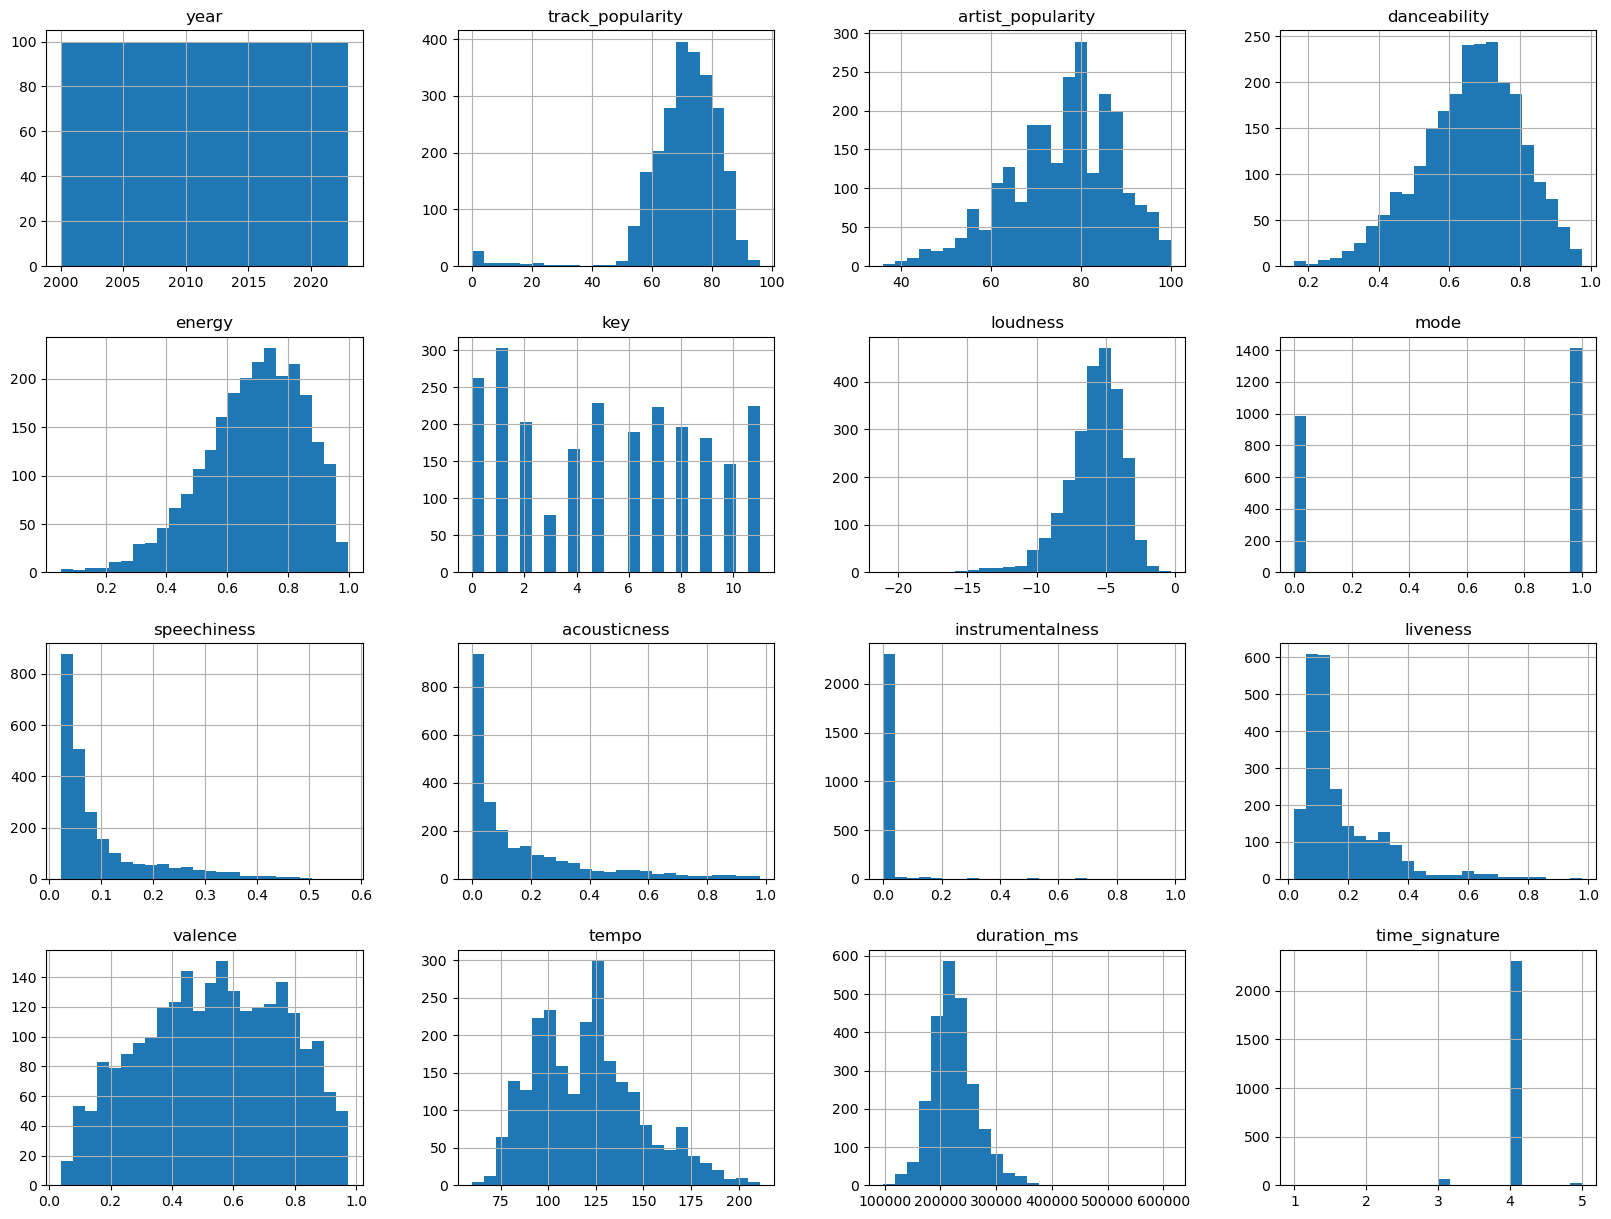

In [945]:
songs_df.hist(bins=24, figsize=(20,15))

### Check for correlations between columns

### NOTE: ran the code commented out in this cell.<br>
Only one pair of column values were correlated (energy/ loudness)<br>

`from pandas.plotting import scatter_matrix
        attributes = ['track_popularity','artist_popularity', 'danceability',\
        'energy','speechiness', 'acousticness',\
        'instrumentalness', 'liveness','valence', 'tempo',

scatter_matrix(songs_df[attributes], figsize=(10,8))`

### Plot correlation between 'energy' 'loudness'

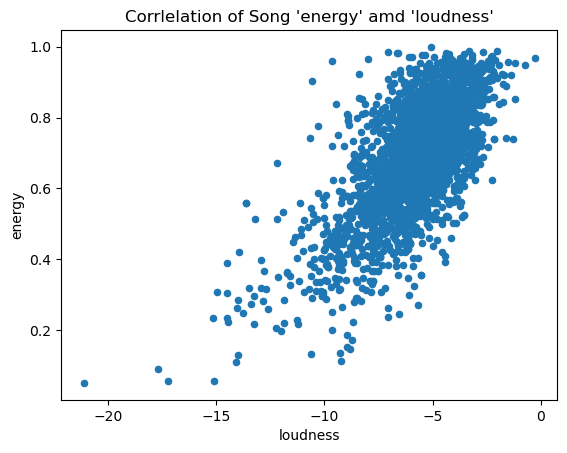

In [952]:
songs_df.plot.scatter(x='loudness', y='energy')
plt.title("Corrlelation of Song 'energy' amd 'loudness'")
plt.show()


### calculate unpopularity threshold as a values less than 3 std deviations<br>
from the mean of popularity score

In [955]:
unpopularity_threshold = calculate_unpopularity_threshold(songs_df, 'three_std')
print(f"Unpopularoty threshold, calculated as score below 3 std from mean mean popularity: {unpopularity_threshold}")

Unpopularoty threshold, calculated as score below 3 std from mean mean popularity: 32


### Count the tracks with popularity less than 3 std deviations from the mean 
- popularity threshhold = 32

In [957]:
track_count_with_popularity_below_32 = (songs_df['track_popularity'] < 32).sum()
print(f"There are {track_count_with_popularity_below_32} tracks with a popularity score less than 31")

There are 54 tracks with a popularity score less than 31


### Observations: 
1. 'loudness' values are negative: shift them to positve
2. 'loudness' and 'energy' are positively correlated
3. The data covers the years 2000 - 2023; every year represented; 100 tracks per year
4. There are no 'null'-containing rows
5. The are 98 duplicate tracks; remove them to leave 2400 - 98 = 2302 unique tracks
6. Taking three standard deviations from the popularity mean as the 'edge of popularity',<br>
(there are 53 unique, unpopular tracks in the data set and 2249 unique, popular tracks
8. Most tracks occur in the higher (more popular) range
9. The popularity of most tracks (2249/ 2301 tracks) is approxximately normally distributed
10. These 14 columns have quantitative values:
- 'track_popularity'
- 'artist_popularity'
- 'danceability'
- 'energy'
- 'key'
- 'loudness'
- 'mode'
- 'speechiness'
- 'acousticness'
- 'instrumentalness'
- 'liveness'
- 'valence'
- 'tempo'
- 'duration_ms'
9. These nine columns have categorical values:
- 'playlist_url'
- 'year'
- 'track_id'
- 'track_name'
- 'album'
- 'artist_id'
- 'artist_name'
- 'artist_genres'
- 'time_signature'
10. Some data columns are probably uninfomative and are candidates for removal
- 'playlist_url'
- 'year'
- 'track_name'
- 'album'
- 'artist_id'
- 'time_signature' (all songs have the same 4/4 time signiture)
11. 'track_id' can be convertedd to the index
12. there are no rows with null values


## Refactor the dataframe

### concatenate 'artist_genres'; write to a new column called 'artist_genres_concat'; delete 'artist_genres'

In [961]:
songs_df = change_sublist_to_concatenated_string(songs_df, 'artist_genres', 'artist_genres_concat')

### transform loudness  by adding 21.107 so lowest value is zero

In [963]:
column_to_transform = ['loudness']
songs_df = transform_neg_column_values_to_pos(songs_df, column_to_transform)
songs_df.head()

loudness


playlist_url  year  \
0  https://open.spotify.com/playlist/37i9dQZF1DWV...  2019   
1  https://open.spotify.com/playlist/6unJBM7ZGitZ...  2023   
2  https://open.spotify.com/playlist/6unJBM7ZGitZ...  2023   
3  https://open.spotify.com/playlist/6unJBM7ZGitZ...  2023   
4  https://open.spotify.com/playlist/6unJBM7ZGitZ...  2023   

                 track_id             track_name  track_popularity  \
0  1BxfuPKGuaTgP7aM0Bbdwr           Cruel Summer                96   
1  1BxfuPKGuaTgP7aM0Bbdwr           Cruel Summer                96   
2  3rUGC1vUpkDG9CZFHMur1t                 greedy                96   
3  3vkCueOmm7xQDoJ17W1Pm3  My Love Mine All Mine                94   
4  4xhsWYTOGcal8zt0J161CU            Lovin On Me                93   

                                    album               artist_id  \
0                                   Lover  06HL4z0CvFAxyc27GXpf02   
1                                   Lover  06HL4z0CvFAxyc27GXpf02   
2                                  greedy  45dkTj5sMRSjrmBSBeiHym   
3  The Land Is Inhospitable and So Are We  2uYWxilOVlUdk4oV9DvwqK   
4                             Lovin On Me  2LIk90788K0zvyj2JJVwkJ   

    artist_name  artist_popularity  danceability  ...  speechiness  \
0  Taylor Swift                100         0.552  ...       0.1570   
1  Taylor Swift                100         0.552  ...       0.1570   
2    Tate McRae                 85         0.750  ...       0.0319   
3        Mitski                 84         0.504  ...       0.0321   
4   Jack Harlow                 83         0.943  ...       0.0568   

   acousticness  instrumentalness  liveness  valence    tempo  duration_ms  \
0        0.1170          0.000021    0.1050    0.564  169.994       178427   
1        0.1170          0.000021    0.1050    0.564  169.994       178427   
2        0.2560          0.000000    0.1140    0.844  111.018       131872   
3        0.8680          0.135000    0.1580    0.121  113.950       137773   
4        0.0026          0.000002    0.0937    0.606  104.983       138411   

   time_signature                               artist_genres_concat  \
0               4                                                pop   
1               4                                                pop   
2               1                                                pop   
3               4                          brooklyn+indie_pov:+indie   
4               4  deep+underground+hip+hop_kentucky+hip+hop_pop+...   

   transformed_loudness  
0                15.124  
1                15.124  
2                17.651  
3                 5.873  
4                15.920  

[5 rows x 23 columns]

### remove duplicate songs from list, keeping the first occurance

In [965]:
songs_df = songs_df.drop_duplicates(subset=['track_id'], keep='first')

### make back-up dictionaries for future reference before purging columns
- {track_id: playlist_url}
- {track_id: track_name}
- {track_id: album}
- {track_id: artist_id}
- {track_id: artist_name}
- {track_id: mode}
- {track_id: time_signature}

In [967]:
back_up_dicts = []
key_column = 'track_id'
value_columns = ['playlist_url', 'year', 'track_name', 'album', 'artist_id', \
                     'artist_name', 'mode', 'time_signature']
for value_column in value_columns:
    dict_name = 'track_id_playlist_' + value_column
    dict_name = make_backup_dict_of_columns(songs_df, key_column, value_column)
    back_up_dicts.append(dict_name)

### remove uninformative columns
- 'year'
- 'playlist_url'
- 'track_name'
- 'album'
- 'artist_name'
- 'artist_id'
- 'mode'
- 'time_signature'

In [975]:
columns_to_remove = ['playlist_url','year','track_name','album','artist_name','artist_id','mode','time_signature' ]
songs_df = remove_columns(songs_df, columns_to_remove)

### check datframe datatypes. (Result: OK)

In [978]:
songs_df.dtypes

track_id                 object
track_popularity          int64
artist_popularity         int64
danceability            float64
energy                  float64
key                       int64
speechiness             float64
acousticness            float64
instrumentalness        float64
liveness                float64
valence                 float64
tempo                   float64
duration_ms               int64
artist_genres_concat     object
transformed_loudness    float64
dtype: object

### check dataframe column names. (Result: OK)

In [981]:
songs_df.columns

Index(['track_id', 'track_popularity', 'artist_popularity', 'danceability',
       'energy', 'key', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'artist_genres_concat',
       'transformed_loudness'],
      dtype='object')

### check dataframe shape. (Result: 2302 rows, OK)

In [984]:
songs_df.shape

(2302, 15)

## Create and add synthetic data to equalize data for popular and unpopular songs
### Note from histograph above that unpopular songs are underepresented in the data
- 'popular' is score from 32 - 100
- 'unpopular' is score less than 32

### create a dataframe of unpopular songs to feed synthetic data generator

In [990]:
unpopular_songs_df  = songs_df[songs_df['track_popularity'] < 32]
unpopular_songs_df.head()

track_id  track_popularity  artist_popularity  \
2346  2b8fOow8UzyDFAE27YhOZM                28                 85   
2347  5PjdY0CKGZdEuoNab3yDmX                28                 79   
2348  6fRxMU4LWwyaSSowV441IU                27                 85   
2349  7lPN2DXiMsVn7XUKtOW1CS                25                 90   
2350  4LRPiXqCikLlN15c3yImP7                23                 85   

      danceability  energy  key  speechiness  acousticness  instrumentalness  \
2346         0.764   0.320   11       0.0546        0.8370          0.000000   
2347         0.591   0.764    1       0.0483        0.0383          0.000000   
2348         0.713   0.676   10       0.0270        0.0377          0.000000   
2349         0.585   0.436   10       0.0601        0.7210          0.000013   
2350         0.520   0.731    6       0.0557        0.3420          0.001010   

      liveness  valence    tempo  duration_ms artist_genres_concat  \
2346    0.0822    0.575   91.019       189486                  pop   
2347    0.1030    0.478  169.928       141806   australian+hip+hop   
2348    0.1540    0.721   99.048       227395                  pop   
2349    0.1050    0.132  143.874       242014                  pop   
2350    0.3110    0.662  173.930       167303                  pop   

      transformed_loudness  
2346                13.622  
2347                15.347  
2348                15.348  
2349                12.070  
2350                15.493

In [992]:
popular_songs_df = songs_df[songs_df['track_popularity'] >= 32]

In [994]:
#unpopular_songs_df = convert_index_to_column(unpopular_songs_df, 'track_id')
unpopular_songs_df = convert_index_to_column(unpopular_songs_df, 'num_id')

In [996]:
unpopular_songs_df.head()

num_id                track_id  track_popularity  artist_popularity  \
0    2346  2b8fOow8UzyDFAE27YhOZM                28                 85   
1    2347  5PjdY0CKGZdEuoNab3yDmX                28                 79   
2    2348  6fRxMU4LWwyaSSowV441IU                27                 85   
3    2349  7lPN2DXiMsVn7XUKtOW1CS                25                 90   
4    2350  4LRPiXqCikLlN15c3yImP7                23                 85   

   danceability  energy  key  speechiness  acousticness  instrumentalness  \
0         0.764   0.320   11       0.0546        0.8370          0.000000   
1         0.591   0.764    1       0.0483        0.0383          0.000000   
2         0.713   0.676   10       0.0270        0.0377          0.000000   
3         0.585   0.436   10       0.0601        0.7210          0.000013   
4         0.520   0.731    6       0.0557        0.3420          0.001010   

   liveness  valence    tempo  duration_ms artist_genres_concat  \
0    0.0822    0.575   91.019       189486                  pop   
1    0.1030    0.478  169.928       141806   australian+hip+hop   
2    0.1540    0.721   99.048       227395                  pop   
3    0.1050    0.132  143.874       242014                  pop   
4    0.3110    0.662  173.930       167303                  pop   

   transformed_loudness  
0                13.622  
1                15.347  
2                15.348  
3                12.070  
4                15.493

In [998]:
unpopular_songs_df.shape

(53, 16)

### create 'metadata' for synthetic data generators

In [1001]:
filepath="./Resources/Metadata/unpopular_songs_augmented_metadata.json"
tablename = 'unpopular_songs_augmented_metadata'
metadata = create_and_save_metadata(unpopular_songs_df, filepath, tablename)

In [1003]:
metadata_dict = metadata.to_dict()
print(metadata_dict)

{'tables': {'unpopular_songs_augmented_metadata': {'columns': {'num_id': {'sdtype': 'id'}, 'track_id': {'sdtype': 'unknown', 'pii': True}, 'track_popularity': {'sdtype': 'numerical'}, 'artist_popularity': {'sdtype': 'numerical'}, 'danceability': {'sdtype': 'numerical'}, 'energy': {'sdtype': 'numerical'}, 'key': {'sdtype': 'numerical'}, 'speechiness': {'sdtype': 'numerical'}, 'acousticness': {'sdtype': 'numerical'}, 'instrumentalness': {'sdtype': 'numerical'}, 'liveness': {'sdtype': 'numerical'}, 'valence': {'sdtype': 'numerical'}, 'tempo': {'sdtype': 'numerical'}, 'duration_ms': {'sdtype': 'numerical'}, 'artist_genres_concat': {'sdtype': 'unknown', 'pii': True}, 'transformed_loudness': {'sdtype': 'numerical'}}, 'primary_key': 'num_id'}}, 'relationships': [], 'METADATA_SPEC_VERSION': 'V1'}


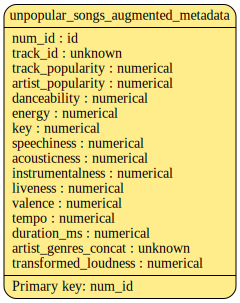

In [1004]:
metadata.visualize()

### inspect and update metadata

In [1008]:
metadata.update_column(
    column_name='track_id',
    sdtype='categorical')
metadata.update_column(
    column_name='artist_genres_concat',
    sdtype='categorical')

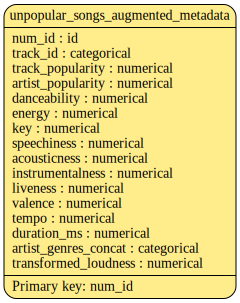

In [1009]:
metadata.visualize()

In [1010]:
# save metadata to json file
filepath="./Resources/Metadata/unpopular_songs_augmented_metadata_edit_1.json"
metadata.save_to_json(filepath)

### generate synthetic data rows with SVD GaussianCopulaSynthesizer
- generate 2242 rows, to create a balanced unpopular/ popular data set

In [1016]:
synthetic_GaussianCopula_df = create_synthetic_data(unpopular_songs_df, metadata, GaussianCopulaSynthesizer, 2242)

In [1017]:
synthetic_GaussianCopula_df.shape

(2242, 16)

In [1020]:
# Save or use the synthetic data
synthetic_GaussianCopula_df.to_csv('./Resources/Synthesized_data/synthetic_GaussianCopula_data_1.csv', index=False)

### import 'synthetic_data.csv' into a pandas dataframe 'synthetic_data_df'

In [1022]:
synthetic_GaussianCopula_df = pd.read_csv('./Resources/Synthesized_data/synthetic_GaussianCopula_data_1.csv')

In [1023]:
synthetic_GaussianCopula_df

num_id                track_id  track_popularity  artist_popularity  \
0     13788158  07bsRv0pcpbG4zJeLsUs1p                14                 75   
1     12626117  1O2pcBJGej0pmH2Y9XZMs6                 6                 82   
2     11795059  2Wo6QQD1KMDWeFkkjLqwx5                20                 91   
3     14576532  3KdoeNlEN0BoAKWzaRLNZa                 3                 86   
4     14035807  2i8f4VnnBjy0yDqH2C452a                23                 93   
...        ...                     ...               ...                ...   
2237  14824705  6PQ88X9TkUIAUIZJHW2upE                 4                 94   
2238   5364411  5PjdY0CKGZdEuoNab3yDmX                28                 86   
2239   2175821  78Sw5GDo6AlGwTwanjXbGh                12                 69   
2240   6418238  7MAibcTli4IisCtbHKrGMh                27                 87   
2241  12435721  27ycaQnQAxaPiyeg3nr2aB                17                 89   

      danceability  energy  key  speechiness  acousticness  instrumentalness  \
0            0.623   0.434   10       0.0643       0.49658      3.839300e-04   
1            0.769   0.725    3       0.0856       0.01383      4.620600e-04   
2            0.797   0.792   10       0.2067       0.11248      9.692000e-05   
3            0.676   0.641    6       0.0620       0.26194      6.560000e-06   
4            0.709   0.663   10       0.0273       0.17552      1.628200e-04   
...            ...     ...  ...          ...           ...               ...   
2237         0.607   0.799    4       0.1260       0.00698      4.077000e-05   
2238         0.733   0.715    4       0.0330       0.67607      1.060600e-04   
2239         0.571   0.673    8       0.0432       0.47964      4.000000e-08   
2240         0.511   0.754    9       0.0423       0.25001      3.279700e-04   
2241         0.557   0.470    8       0.0591       0.03965      1.043000e-05   

      liveness  valence    tempo  duration_ms  \
0       0.0598   0.5615  128.174       183144   
1       0.0894   0.5196  101.696       154507   
2       0.0823   0.8093  106.360       190032   
3       0.1045   0.7519  127.314       178770   
4       0.2001   0.1651  105.977       298210   
...        ...      ...      ...          ...   
2237    0.2844   0.5343  136.037       203235   
2238    0.0689   0.6459  171.579       182863   
2239    0.2769   0.4072  121.469       214785   
2240    0.4250   0.5279  179.254       219899   
2241    0.4356   0.1804  132.022       195655   

                                   artist_genres_concat  transformed_loudness  
0                                           hip+hop_rap             12.770441  
1     alt+z_gen+z+singer-songwriter_singer-songwrite...             15.689579  
2                                                   pop             16.793569  
3                                           melodic+rap             15.547594  
4                                                   pop             15.087327  
...                                                 ...                   ...  
2237                                      dance+pop_pop             16.929689  
2238                                                pop             14.781840  
2239                         r&b_rap_urban+contemporary             15.766624  
2240                                                pop             15.438385  
2241         canadian+contemporary+r&b_canadian+pop_pop             11.437871  

[2242 rows x 16 columns]

### change track_id values to '123pseudoID'
- this synthetic entries dont have a real 'track_id'

In [1034]:
track_pseudo_id_list = []
for i in range(len(synthetic_GaussianCopula_df)):
    pseudo_id = 'pseudoID_' + str(i)
    track_pseudo_id_list.append(pseudo_id)
print(track_pseudo_id_list[0:5])
synthetic_GaussianCopula_df['track_id'] = track_pseudo_id_list

['pseudoID_0', 'pseudoID_1', 'pseudoID_2', 'pseudoID_3', 'pseudoID_4']


In [1039]:
synthetic_GaussianCopula_df.head()
synthetic_GaussianCopula_df.shape

(2242, 16)

### compare synthetic to real data

In [1042]:
quality_report = evaluate_quality(
    unpopular_songs_df,
    synthetic_GaussianCopula_df,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 16/16 [00:00<00:00, 274.90it/s]|
Column Shapes Score: 80.75%

(2/2) Evaluating Column Pair Trends: |██████████| 120/120 [00:00<00:00, 513.33it/s]|
Column Pair Trends Score: 75.82%

Overall Score (Average): 78.29%



In [1044]:
synthetic_GaussianCopula_df.columns

Index(['num_id', 'track_id', 'track_popularity', 'artist_popularity',
       'danceability', 'energy', 'key', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'artist_genres_concat', 'transformed_loudness'],
      dtype='object')

column name: track_popularity


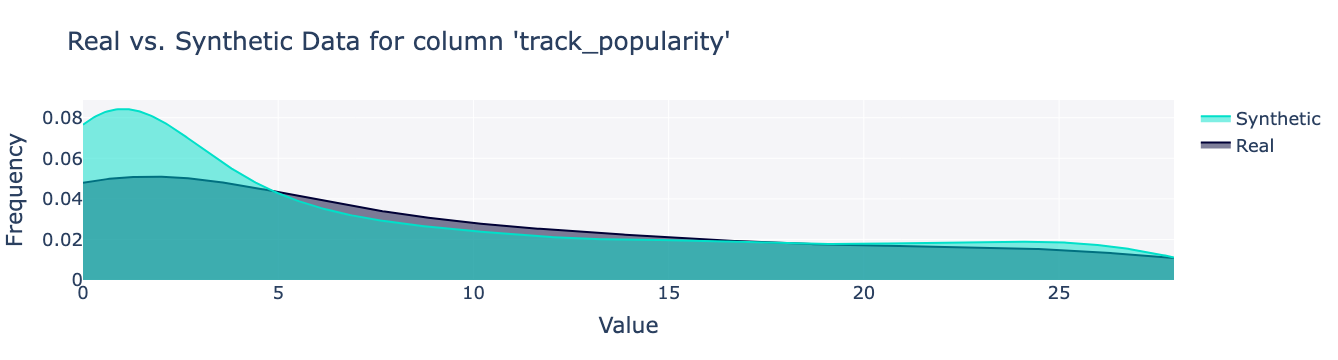

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
column name: artist_popularity


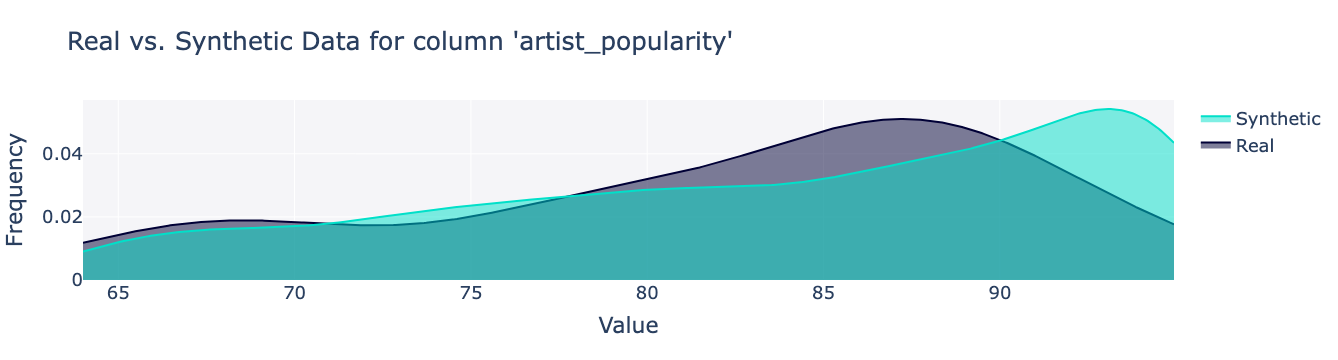

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
column name: danceability


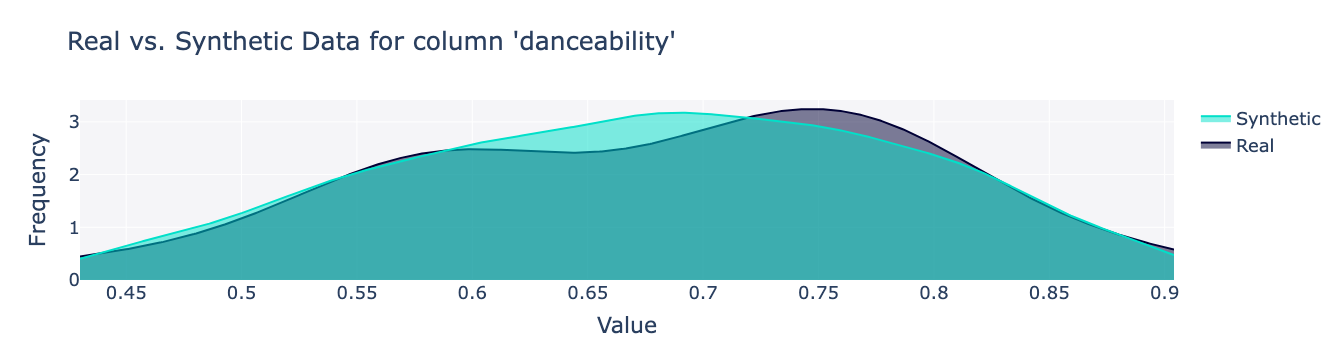

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
column name: energy


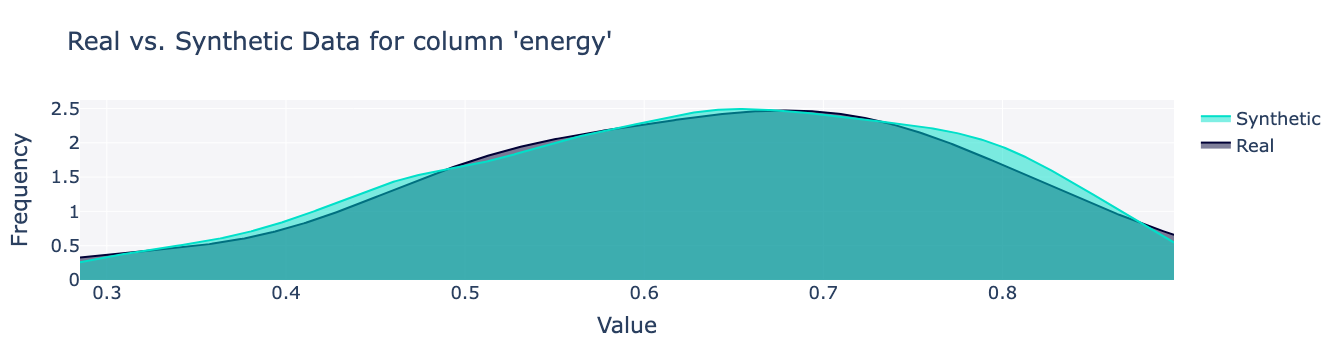

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
column name: key


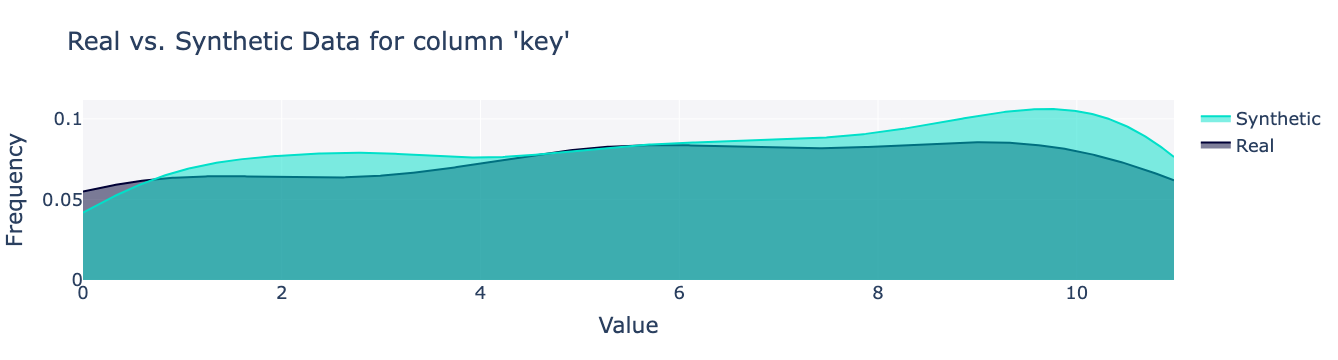

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
column name: speechiness


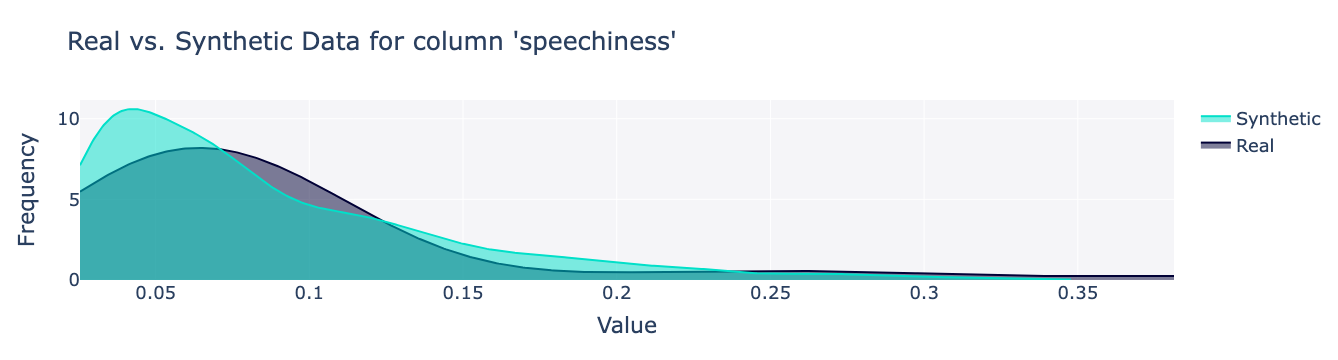

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
column name: acousticness


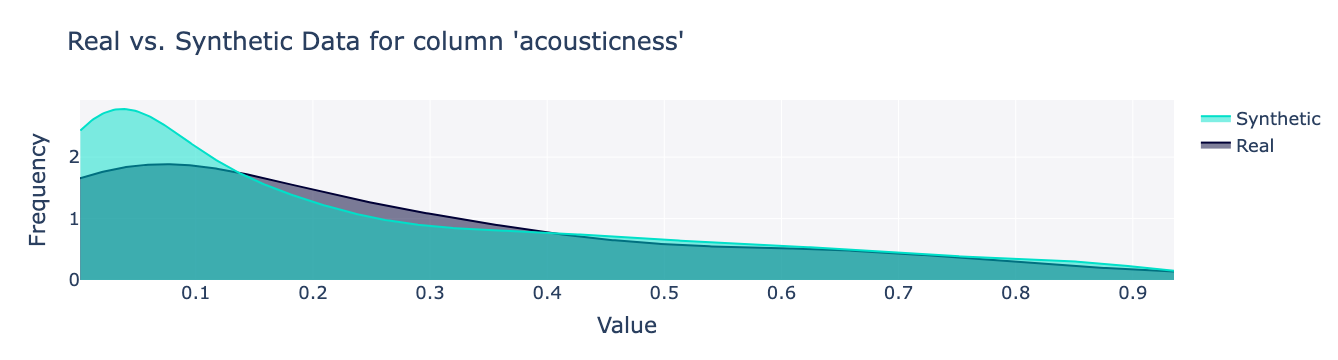

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
column name: instrumentalness


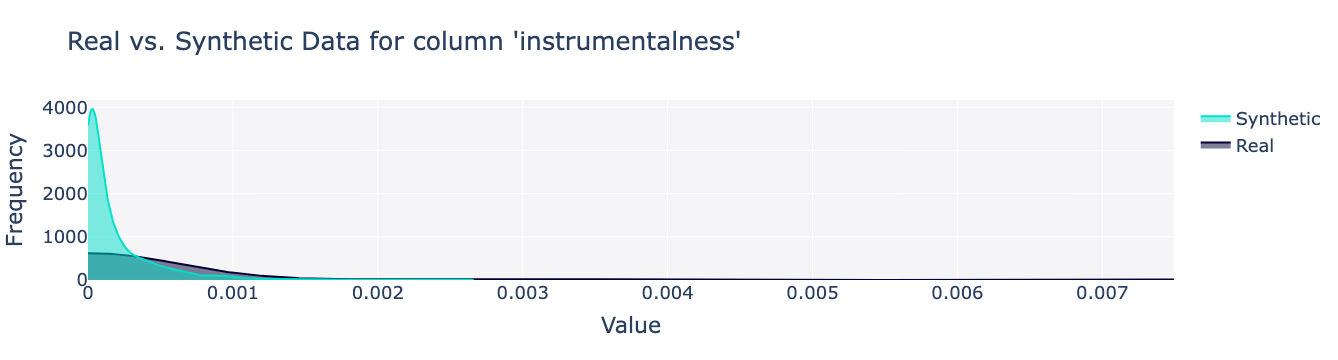

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
column name: liveness


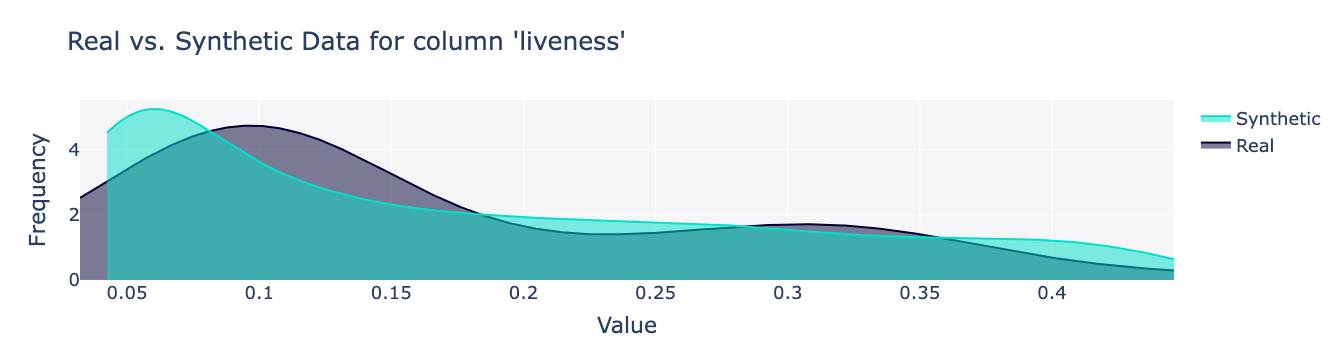

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
column name: valence


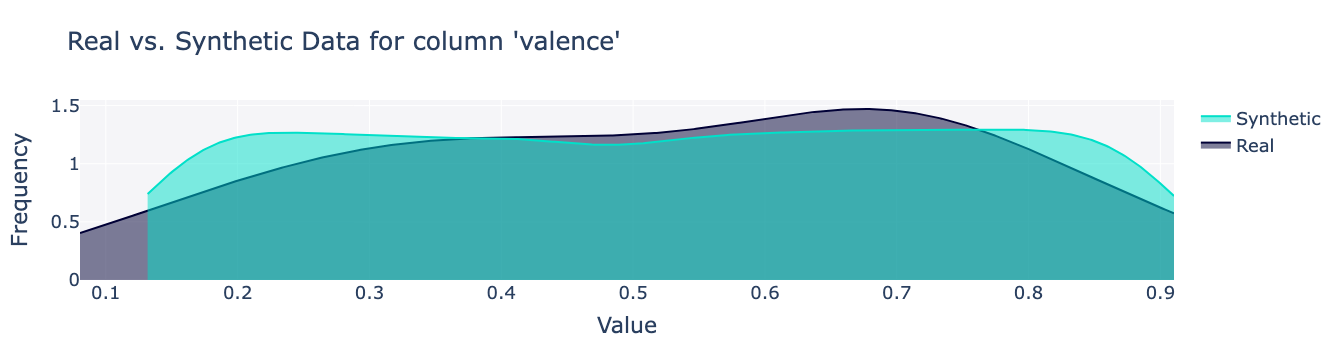

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
column name: tempo


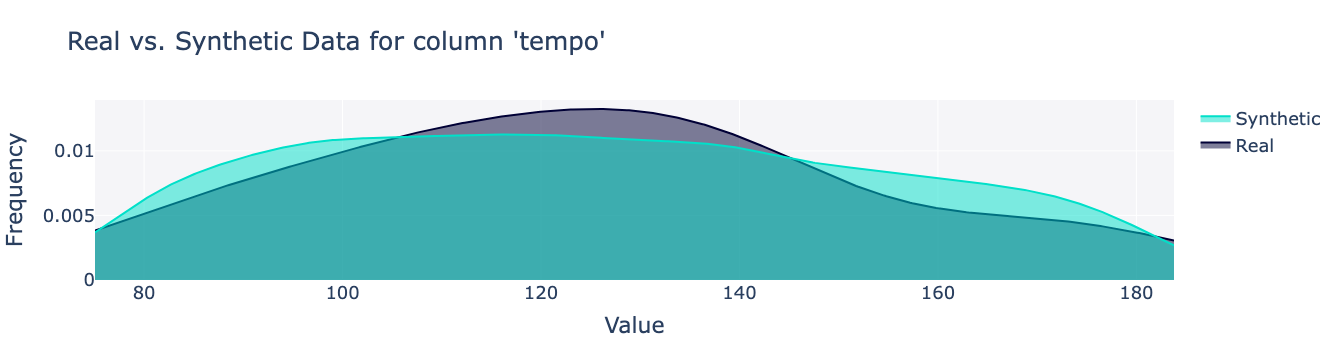

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
column name: duration_ms


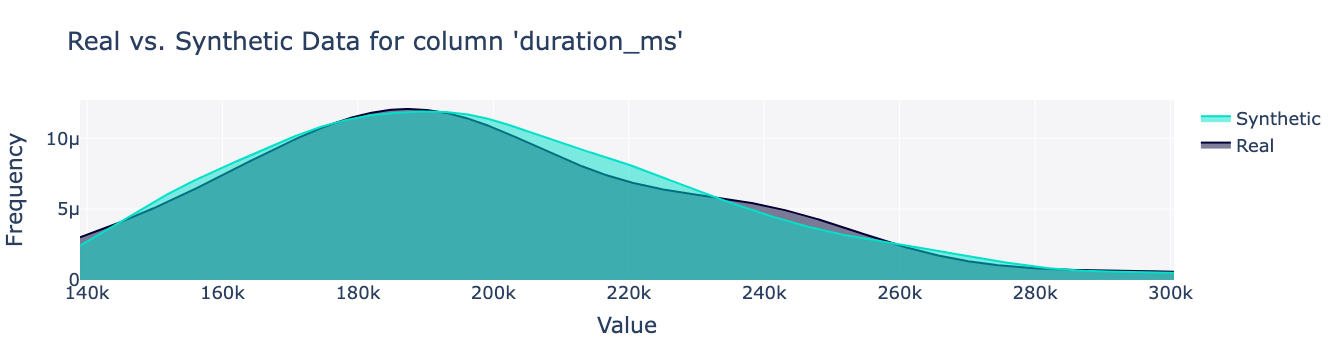

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
column name: transformed_loudness


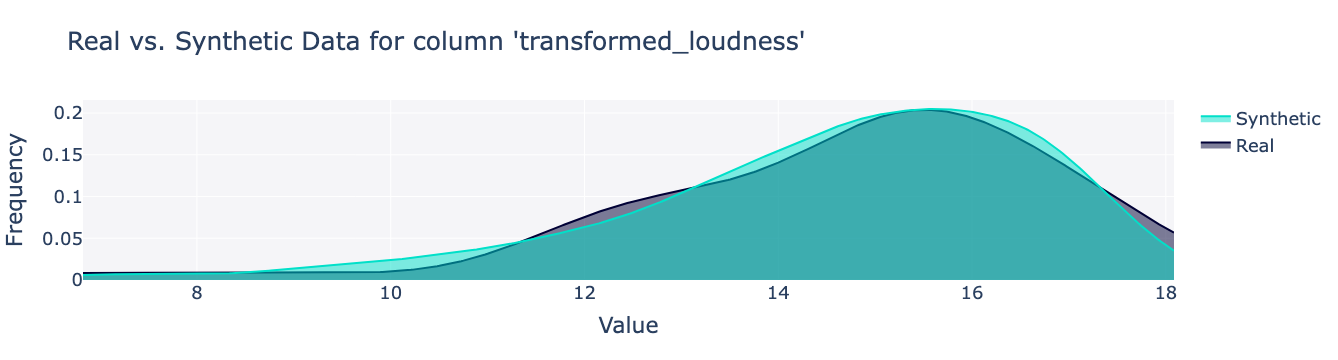

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [1046]:
column_names_to_plot= ['track_popularity', 'artist_popularity', 'danceability',\
                       'energy', 'key', 'speechiness', 'acousticness',\
                       'instrumentalness', 'liveness', 'valence', 'tempo',\
                       'duration_ms', 'transformed_loudness']
for column_name in column_names_to_plot:
    print(f"column name: {column_name}")
    fig = get_column_plot(column_name=column_name, real_data=unpopular_songs_df, synthetic_data=synthetic_GaussianCopula_df, metadata=metadata)
    fig.show()
    print('+' * 100)

### check compatible columns

In [1048]:
synth_col = list(synthetic_GaussianCopula_df.columns)
unpop_col = list(unpopular_songs_df.columns)
popular_col = list(popular_songs_df.columns)
songs_col = list(songs_df.columns)
list_of_lists = [synth_col, unpop_col, popular_col, songs_col]
list_equivilence_dict = test_lists_for_identity(list_of_lists)
for key,value in list_equivilence_dict.items():
   print(f"{key}: {value}")

list_0_to_list_1: equivilent
list_0_to_list_2: NOT equivilent
list_1_to_list_2: NOT equivilent


In [1051]:
synthetic_GaussianCopula_df.columns

Index(['num_id', 'track_id', 'track_popularity', 'artist_popularity',
       'danceability', 'energy', 'key', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'artist_genres_concat', 'transformed_loudness'],
      dtype='object')

In [1053]:
unpopular_songs_df.columns

Index(['num_id', 'track_id', 'track_popularity', 'artist_popularity',
       'danceability', 'energy', 'key', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'artist_genres_concat', 'transformed_loudness'],
      dtype='object')

In [1055]:
songs_df.columns

Index(['track_id', 'track_popularity', 'artist_popularity', 'danceability',
       'energy', 'key', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'artist_genres_concat',
       'transformed_loudness'],
      dtype='object')

### remove 'num_id' from synthetic_GaussianCopula_df and unpopular_songs_df.columns
- (added to satisfy synthesizer requirement, unneeded otherwise)

In [1058]:
synthetic_GaussianCopula_df.drop('num_id', axis=1, inplace=True)
unpopular_songs_df.drop('num_id', axis=1, inplace=True)

In [1060]:
synth_col = list(synthetic_GaussianCopula_df.columns)
unpop_col = list(unpopular_songs_df.columns)
popular_col = list(popular_songs_df.columns)
songs_col = list(songs_df.columns)
list_of_lists = [synth_col, unpop_col, popular_col, songs_col]
list_equivilence_dict = test_lists_for_identity(list_of_lists)
for key,value in list_equivilence_dict.items():
   print(f"{key}: {value}")

list_0_to_list_1: equivilent
list_0_to_list_2: equivilent
list_1_to_list_2: equivilent


### add a popularity_class column  to the dataframes
- 0 = unpopular
- 1 = popular

In [1063]:
synthetic_GaussianCopula_df = add_column_to_dataframe_and_fill_with_a_value(synthetic_GaussianCopula_df, 'popularity_class', 0)
unpopular_songs_df = add_column_to_dataframe_and_fill_with_a_value(unpopular_songs_df, 'popularity_class', 0)
popular_songs_df = add_column_to_dataframe_and_fill_with_a_value(popular_songs_df, 'popularity_class', 1)

In [1065]:
list_equivilence_dict = test_lists_for_identity(list_of_lists)
for key,value in list_equivilence_dict.items():
   print(f"{key}: {value}")

list_0_to_list_1: equivilent
list_0_to_list_2: equivilent
list_1_to_list_2: equivilent


In [1067]:
synthetic_GaussianCopula_df.head(5)

track_id  track_popularity  artist_popularity  danceability  energy  key  \
0  pseudoID_0                14                 75         0.623   0.434   10   
1  pseudoID_1                 6                 82         0.769   0.725    3   
2  pseudoID_2                20                 91         0.797   0.792   10   
3  pseudoID_3                 3                 86         0.676   0.641    6   
4  pseudoID_4                23                 93         0.709   0.663   10   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0643       0.49658          0.000384    0.0598   0.5615  128.174   
1       0.0856       0.01383          0.000462    0.0894   0.5196  101.696   
2       0.2067       0.11248          0.000097    0.0823   0.8093  106.360   
3       0.0620       0.26194          0.000007    0.1045   0.7519  127.314   
4       0.0273       0.17552          0.000163    0.2001   0.1651  105.977   

   duration_ms                               artist_genres_concat  \
0       183144                                        hip+hop_rap   
1       154507  alt+z_gen+z+singer-songwriter_singer-songwrite...   
2       190032                                                pop   
3       178770                                        melodic+rap   
4       298210                                                pop   

   transformed_loudness  popularity_class  
0             12.770441                 0  
1             15.689579                 0  
2             16.793569                 0  
3             15.547594                 0  
4             15.087327                 0

In [1069]:
unpopular_songs_df.head(5)

track_id  track_popularity  artist_popularity  danceability  \
0  2b8fOow8UzyDFAE27YhOZM                28                 85         0.764   
1  5PjdY0CKGZdEuoNab3yDmX                28                 79         0.591   
2  6fRxMU4LWwyaSSowV441IU                27                 85         0.713   
3  7lPN2DXiMsVn7XUKtOW1CS                25                 90         0.585   
4  4LRPiXqCikLlN15c3yImP7                23                 85         0.520   

   energy  key  speechiness  acousticness  instrumentalness  liveness  \
0   0.320   11       0.0546        0.8370          0.000000    0.0822   
1   0.764    1       0.0483        0.0383          0.000000    0.1030   
2   0.676   10       0.0270        0.0377          0.000000    0.1540   
3   0.436   10       0.0601        0.7210          0.000013    0.1050   
4   0.731    6       0.0557        0.3420          0.001010    0.3110   

   valence    tempo  duration_ms artist_genres_concat  transformed_loudness  \
0    0.575   91.019       189486                  pop                13.622   
1    0.478  169.928       141806   australian+hip+hop                15.347   
2    0.721   99.048       227395                  pop                15.348   
3    0.132  143.874       242014                  pop                12.070   
4    0.662  173.930       167303                  pop                15.493   

   popularity_class  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [1070]:
popular_songs_df.head(5)

track_id  track_popularity  artist_popularity  danceability  \
0  1BxfuPKGuaTgP7aM0Bbdwr                96                100         0.552   
2  3rUGC1vUpkDG9CZFHMur1t                96                 85         0.750   
3  3vkCueOmm7xQDoJ17W1Pm3                94                 84         0.504   
4  4xhsWYTOGcal8zt0J161CU                93                 83         0.943   
5  5XeFesFbtLpXzIVDNQP22n                93                 86         0.464   

   energy  key  speechiness  acousticness  instrumentalness  liveness  \
0   0.702    9       0.1570        0.1170          0.000021    0.1050   
2   0.733    6       0.0319        0.2560          0.000000    0.1140   
3   0.308    9       0.0321        0.8680          0.135000    0.1580   
4   0.558    2       0.0568        0.0026          0.000002    0.0937   
5   0.417    0       0.0256        0.1360          0.022000    0.0974   

   valence    tempo  duration_ms  \
0    0.564  169.994       178427   
2    0.844  111.018       131872   
3    0.121  113.950       137773   
4    0.606  104.983       138411   
5    0.479   67.528       183956   

                                artist_genres_concat  transformed_loudness  \
0                                                pop                15.124   
2                                                pop                17.651   
3                          brooklyn+indie_pov:+indie                 5.873   
4  deep+underground+hip+hop_kentucky+hip+hop_pop+...                15.920   
5  garage+rock_modern+rock_permanent+wave_rock_sh...                11.486   

   popularity_class  
0                 1  
2                 1  
3                 1  
4                 1  
5                 1

In [1073]:
## Merge dataframes

### merge 'synthetic unpopular', 'real unpopular' and 'real popular' data
- synthetic_GaussianCopula_df
- unpopular_songs_df
- popular_songs_df

In [1076]:
df_list = [synthetic_GaussianCopula_df, unpopular_songs_df, popular_songs_df]
merged_df = pd.concat(df_list).reset_index(drop=True)

In [1078]:
merged_df.shape

(4544, 16)

In [1080]:
merged_df.head()

track_id  track_popularity  artist_popularity  danceability  energy  key  \
0  pseudoID_0                14                 75         0.623   0.434   10   
1  pseudoID_1                 6                 82         0.769   0.725    3   
2  pseudoID_2                20                 91         0.797   0.792   10   
3  pseudoID_3                 3                 86         0.676   0.641    6   
4  pseudoID_4                23                 93         0.709   0.663   10   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0643       0.49658          0.000384    0.0598   0.5615  128.174   
1       0.0856       0.01383          0.000462    0.0894   0.5196  101.696   
2       0.2067       0.11248          0.000097    0.0823   0.8093  106.360   
3       0.0620       0.26194          0.000007    0.1045   0.7519  127.314   
4       0.0273       0.17552          0.000163    0.2001   0.1651  105.977   

   duration_ms                               artist_genres_concat  \
0       183144                                        hip+hop_rap   
1       154507  alt+z_gen+z+singer-songwriter_singer-songwrite...   
2       190032                                                pop   
3       178770                                        melodic+rap   
4       298210                                                pop   

   transformed_loudness  popularity_class  
0             12.770441                 0  
1             15.689579                 0  
2             16.793569                 0  
3             15.547594                 0  
4             15.087327                 0

### recast 'genres_concat' back to 'genres'

In [1083]:
merged_restored_df = unconcatenate_dataframe_column(merged_df, 'artist_genres_concat', 'artist_genres') 
merged_restored_df.head()

track_id  track_popularity  artist_popularity  danceability  energy  key  \
0  pseudoID_0                14                 75         0.623   0.434   10   
1  pseudoID_1                 6                 82         0.769   0.725    3   
2  pseudoID_2                20                 91         0.797   0.792   10   
3  pseudoID_3                 3                 86         0.676   0.641    6   
4  pseudoID_4                23                 93         0.709   0.663   10   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0643       0.49658          0.000384    0.0598   0.5615  128.174   
1       0.0856       0.01383          0.000462    0.0894   0.5196  101.696   
2       0.2067       0.11248          0.000097    0.0823   0.8093  106.360   
3       0.0620       0.26194          0.000007    0.1045   0.7519  127.314   
4       0.0273       0.17552          0.000163    0.2001   0.1651  105.977   

   duration_ms  transformed_loudness  popularity_class  \
0       183144             12.770441                 0   
1       154507             15.689579                 0   
2       190032             16.793569                 0   
3       178770             15.547594                 0   
4       298210             15.087327                 0   

                                       artist_genres  
0                                     [hip hop, rap]  
1  [alt z, gen z singer-songwriter, singer-songwr...  
2                                              [pop]  
3                                      [melodic rap]  
4                                              [pop]

In [1085]:
merged_restored_df.head()

track_id  track_popularity  artist_popularity  danceability  energy  key  \
0  pseudoID_0                14                 75         0.623   0.434   10   
1  pseudoID_1                 6                 82         0.769   0.725    3   
2  pseudoID_2                20                 91         0.797   0.792   10   
3  pseudoID_3                 3                 86         0.676   0.641    6   
4  pseudoID_4                23                 93         0.709   0.663   10   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0643       0.49658          0.000384    0.0598   0.5615  128.174   
1       0.0856       0.01383          0.000462    0.0894   0.5196  101.696   
2       0.2067       0.11248          0.000097    0.0823   0.8093  106.360   
3       0.0620       0.26194          0.000007    0.1045   0.7519  127.314   
4       0.0273       0.17552          0.000163    0.2001   0.1651  105.977   

   duration_ms  transformed_loudness  popularity_class  \
0       183144             12.770441                 0   
1       154507             15.689579                 0   
2       190032             16.793569                 0   
3       178770             15.547594                 0   
4       298210             15.087327                 0   

                                       artist_genres  
0                                     [hip hop, rap]  
1  [alt z, gen z singer-songwriter, singer-songwr...  
2                                              [pop]  
3                                      [melodic rap]  
4                                              [pop]

In [1087]:
merged_restored_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4544 entries, 0 to 4543
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_id              4544 non-null   object 
 1   track_popularity      4544 non-null   int64  
 2   artist_popularity     4544 non-null   int64  
 3   danceability          4544 non-null   float64
 4   energy                4544 non-null   float64
 5   key                   4544 non-null   int64  
 6   speechiness           4544 non-null   float64
 7   acousticness          4544 non-null   float64
 8   instrumentalness      4544 non-null   float64
 9   liveness              4544 non-null   float64
 10  valence               4544 non-null   float64
 11  tempo                 4544 non-null   float64
 12  duration_ms           4544 non-null   int64  
 13  transformed_loudness  4544 non-null   float64
 14  popularity_class      4544 non-null   int64  
 15  artist_genres        

### move 'track_id' to index

In [1090]:
#column_to_convert = 'track_id'
#merged_restored_df = convert_column_to_index(merged_restored_df, column_to_convert)
#merged_restored_df.info()

In [1092]:
### drop 'track_id'

In [1095]:
merged_restored_df_archive = merged_restored_df.copy()
merged_restored_onehot_df = merged_restored_df.copy()

In [1097]:
merged_restored_onehot_df.head()

track_id  track_popularity  artist_popularity  danceability  energy  key  \
0  pseudoID_0                14                 75         0.623   0.434   10   
1  pseudoID_1                 6                 82         0.769   0.725    3   
2  pseudoID_2                20                 91         0.797   0.792   10   
3  pseudoID_3                 3                 86         0.676   0.641    6   
4  pseudoID_4                23                 93         0.709   0.663   10   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0643       0.49658          0.000384    0.0598   0.5615  128.174   
1       0.0856       0.01383          0.000462    0.0894   0.5196  101.696   
2       0.2067       0.11248          0.000097    0.0823   0.8093  106.360   
3       0.0620       0.26194          0.000007    0.1045   0.7519  127.314   
4       0.0273       0.17552          0.000163    0.2001   0.1651  105.977   

   duration_ms  transformed_loudness  popularity_class  \
0       183144             12.770441                 0   
1       154507             15.689579                 0   
2       190032             16.793569                 0   
3       178770             15.547594                 0   
4       298210             15.087327                 0   

                                       artist_genres  
0                                     [hip hop, rap]  
1  [alt z, gen z singer-songwriter, singer-songwr...  
2                                              [pop]  
3                                      [melodic rap]  
4                                              [pop]

## test rf classifier with one-hot encoded 'artist_generes'

### one-hot encode 'artist_generes'

In [1101]:
merged_restored_onehot_df = convert_index_to_column(merged_restored_onehot_df, 'track_id')

In [1103]:
merged_restored_onehot_df.head()

track_id    track_id  track_popularity  artist_popularity  danceability  \
0        0  pseudoID_0                14                 75         0.623   
1        1  pseudoID_1                 6                 82         0.769   
2        2  pseudoID_2                20                 91         0.797   
3        3  pseudoID_3                 3                 86         0.676   
4        4  pseudoID_4                23                 93         0.709   

   energy  key  speechiness  acousticness  instrumentalness  liveness  \
0   0.434   10       0.0643       0.49658          0.000384    0.0598   
1   0.725    3       0.0856       0.01383          0.000462    0.0894   
2   0.792   10       0.2067       0.11248          0.000097    0.0823   
3   0.641    6       0.0620       0.26194          0.000007    0.1045   
4   0.663   10       0.0273       0.17552          0.000163    0.2001   

   valence    tempo  duration_ms  transformed_loudness  popularity_class  \
0   0.5615  128.174       183144             12.770441                 0   
1   0.5196  101.696       154507             15.689579                 0   
2   0.8093  106.360       190032             16.793569                 0   
3   0.7519  127.314       178770             15.547594                 0   
4   0.1651  105.977       298210             15.087327                 0   

                                       artist_genres  
0                                     [hip hop, rap]  
1  [alt z, gen z singer-songwriter, singer-songwr...  
2                                              [pop]  
3                                      [melodic rap]  
4                                              [pop]

In [1105]:
#merged_restored_onehot_df = merged_restored_df.copy()

merged_restored_onehot_df = one_hot_encode_genres(merged_restored_onehot_df, 'artist_genres', 8)

row_count: 4544
all_genres_list: 12662
['hip_hop', 'rap', 'alt_z', 'gen_z_singer-songwriter', 'singer-songwriter_pop']
length unique_genre_keepers: ['pop', 'rap', 'dance_pop', 'pop_rap', 'hip_hop', 'k-pop', 'r&b', 'urban_contemporary', 'uk_pop', 'singer-songwriter_pop', 'k-pop_boy_group', 'art_pop', 'trap', 'melodic_rap', 'modern_rock', 'canadian_pop', 'chicago_rap', 'rock', 'southern_hip_hop', 'hip_pop', 'edm', 'pop_dance', 'permanent_wave', 'alt_z', 'boy_band', 'urbano_latino', 'neo_mellow', 'gangster_rap', 'metropopolis', 'atl_hip_hop', 'pov:_indie', 'indietronica', 'post-grunge', 'post-teen_pop', 'alternative_metal', 'talent_show', 'viral_pop', 'pop_rock', 'dirty_south_rap', 'ohio_hip_hop', 'canadian_contemporary_r&b', 'piano_rock', 'west_coast_rap', 'nz_pop', 'slap_house', 'conscious_hip_hop', 'contemporary_r&b', 'k-pop_girl_group', 'trap_latino', 'gauze_pop', 'shiver_pop', 'singer-songwriter', 'new_wave_pop', 'kentucky_hip_hop', 'reggaeton', 'deep_underground_hip_hop', 'baroque_p

In [1107]:
merged_restored_onehot_df.head()

track_id    track_id  track_popularity  artist_popularity  danceability  \
0        0  pseudoID_0                14                 75         0.623   
1        1  pseudoID_1                 6                 82         0.769   
2        2  pseudoID_2                20                 91         0.797   
3        3  pseudoID_3                 3                 86         0.676   
4        4  pseudoID_4                23                 93         0.709   

   energy  key  speechiness  acousticness  instrumentalness  ...  \
0   0.434   10       0.0643       0.49658          0.000384  ...   
1   0.725    3       0.0856       0.01383          0.000462  ...   
2   0.792   10       0.2067       0.11248          0.000097  ...   
3   0.641    6       0.0620       0.26194          0.000007  ...   
4   0.663   10       0.0273       0.17552          0.000163  ...   

   stomp_and_holler  latin_hip_hop  filter_house  emo  reggae_fusion  \
0                 0              0             0    0              0   
1                 0              0             0    0              0   
2                 0              0             0    0              0   
3                 0              0             0    0              0   
4                 0              0             0    0              0   

   disco_house swedish_pop  modern_country_rock  german_techno  genre_other  
0            0           0                    0              0            1  
1            0           0                    0              0            1  
2            0           0                    0              0            1  
3            0           0                    0              0            1  
4            0           0                    0              0            1  

[5 rows x 155 columns]

## Classification Analysis

### randomforest classification on merged_restored_df
- this version of the data HAS been one-hot encoded for 'artist_genres'

### make and run a random forest model on the onehot encoded data
- data in 'merged_restored_onehot_df'

### move 'track_id" to index

In [1113]:
column_to_convert = 'track_id'
merged_restored_onehot_df = convert_column_to_index(merged_restored_onehot_df, column_to_convert)

In [1115]:
merged_restored_onehot_df.head()

track_popularity  artist_popularity  danceability  energy  \
track_id                                                                     
(0, pseudoID_0)                14                 75         0.623   0.434   
(1, pseudoID_1)                 6                 82         0.769   0.725   
(2, pseudoID_2)                20                 91         0.797   0.792   
(3, pseudoID_3)                 3                 86         0.676   0.641   
(4, pseudoID_4)                23                 93         0.709   0.663   

                 key  speechiness  acousticness  instrumentalness  liveness  \
track_id                                                                      
(0, pseudoID_0)   10       0.0643       0.49658          0.000384    0.0598   
(1, pseudoID_1)    3       0.0856       0.01383          0.000462    0.0894   
(2, pseudoID_2)   10       0.2067       0.11248          0.000097    0.0823   
(3, pseudoID_3)    6       0.0620       0.26194          0.000007    0.1045   
(4, pseudoID_4)   10       0.0273       0.17552          0.000163    0.2001   

                 valence  ...  stomp_and_holler  latin_hip_hop  filter_house  \
track_id                  ...                                                  
(0, pseudoID_0)   0.5615  ...                 0              0             0   
(1, pseudoID_1)   0.5196  ...                 0              0             0   
(2, pseudoID_2)   0.8093  ...                 0              0             0   
(3, pseudoID_3)   0.7519  ...                 0              0             0   
(4, pseudoID_4)   0.1651  ...                 0              0             0   

                 emo reggae_fusion  disco_house  swedish_pop  \
track_id                                                       
(0, pseudoID_0)    0             0            0            0   
(1, pseudoID_1)    0             0            0            0   
(2, pseudoID_2)    0             0            0            0   
(3, pseudoID_3)    0             0            0            0   
(4, pseudoID_4)    0             0            0            0   

                 modern_country_rock  german_techno  genre_other  
track_id                                                          
(0, pseudoID_0)                    0              0            1  
(1, pseudoID_1)                    0              0            1  
(2, pseudoID_2)                    0              0            1  
(3, pseudoID_3)                    0              0            1  
(4, pseudoID_4)                    0              0            1  

[5 rows x 153 columns]

In [1130]:
nulls_per_column = merged_restored_onehot_df.isnull().sum()
print(nulls_per_column)
total_nulls = merged_restored_onehot_df.isnull().sum().sum()
print("\nTotal nulls:", total_nulls)
column_lengths = merged_restored_onehot_df.apply(len)
for i in range(len(column_lengths)):
    if column_lengths[i] != 4544:
        print(column_lengths[i])

track_popularity       0
artist_popularity      0
danceability           0
energy                 0
key                    0
                      ..
disco_house            0
swedish_pop            0
modern_country_rock    0
german_techno          0
genre_other            0
Length: 153, dtype: int64

Total nulls: 0


/var/folders/2v/kgb9p_hn6ss9mqhg1hbvvgxh0000gn/T/ipykernel_26257/2743840149.py:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



### make and run rf model

In [1163]:
y_column_name = 'popularity_class'
random_state = 42
n_estimators = 500
rf_onehot_results_list = make_and_run_RandomForestModel(merged_restored_onehot_df, y_column_name, random_state, n_estimators)

type X_train: <class 'pandas.core.frame.DataFrame'>


### display model evalution 
- IMPORTANT NOTE: do not name this 'accuracy_score' -- this overwrites<br>
the definition of the function 'accuracy_score', causing an error

In [1168]:
confusion_matrix_df = rf_onehot_results_list[2]
accu_score = rf_onehot_results_list[3]
class_report = rf_onehot_results_list[4]

In [1170]:
print("Confusion Matrix:")
display(confusion_matrix_df)

Confusion Matrix:


Predicted 0  Predicted 1
Actual 0          592            0
Actual 1            1          543

In [1172]:
print(f"Accuracy Score: {accu_score}")

Accuracy Score: 0.9991197183098591


In [1174]:
print(class_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       592
           1       1.00      1.00      1.00       544

    accuracy                           1.00      1136
   macro avg       1.00      1.00      1.00      1136
weighted avg       1.00      1.00      1.00      1136



## Classification Analysis

### randomforest classification on merged_restored_df 
- this version of the data HAS NOT been one-hot encoded for 'artist_generes'
- 'artist_genres' 
- data in 'dropped_generes_df'

### test drop artist_generes

In [ ]:
dropped_generes_df = merged_restored_df.drop(columns='artist_genres')
dropped_generes_df.info()

### make and run a random forest model

In [5247]:
y_column_name = 'popularity_class'
random_state = 42
n_estimators = 500
rf_results_list = make_and_run_RandomForestModel(dropped_generes_df, y_column_name, random_state, n_estimators)

### display model evalution 
- IMORTANT NOTE: do not name htis 'accuracy_score' -- this overwrites<br>
the definetion of the function 'accuracy_score', causing an error


In [5249]:
confusion_matrix_df = rf_results_list[2]
accu_score = rf_results_list[3]
class_report = rf_results_list[4]

In [5256]:
print("Confusion Matrix:")
display(confusion_matrix_df)

Confusion Matrix:


Predicted 0  Predicted 1
Actual 0          556            0
Actual 1            0          580

In [5257]:
print(f"Accuracy Score: {accu_score}")

Accuracy Score: 1.0


In [5258]:
print(class_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       556
           1       1.00      1.00      1.00       580

    accuracy                           1.00      1136
   macro avg       1.00      1.00      1.00      1136
weighted avg       1.00      1.00      1.00      1136



## one-hot encode 'artist_genres' column of merged_restored_df

In [5263]:
target_column = 'artist_genres'
genre_retain_threshold = 8
merged_restored_onhot_df = one_hot_encode_genres(merged_restored_df, target_column, genre_retain_threshold)

/var/folders/2v/kgb9p_hn6ss9mqhg1hbvvgxh0000gn/T/ipykernel_39927/2327844872.py:45: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/2v/kgb9p_hn6ss9mqhg1hbvvgxh0000gn/T/ipykernel_39927/2327844872.py:45: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/2v/kgb9p_hn6ss9mqhg1hbvvgxh0000gn/T/ipykernel_39927/2327844872.py:45: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

NameError: name 'rows_count' is not defined

In [ ]:
merged_restored_onhot_df.columns

# ++++++++++++++++++++++++++++++++++++++++++++++++++

# ++++++++++++++++++++++++++++++++++++++++++++++++++

In [1061]:
from sdv.single_table import CTGANSynthesizer

# Create a synthesizer model
synthesizer_CTGANSynth = CTGANSynthesizer(metadata)

# Fit the synthesizer to the real data
synthesizer_CTGANSynth.fit(unpopular_songs_augmented_df)

# Generate synthetic data (e.g., 1000 samples)
synthetic_data_CTGANSynth = synthesizer_CTGANSynth.sample(2302 - 62)

In [1062]:
# Save or use the synthetic data
synthetic_data_CTGANSynth.to_csv('./synthetic_CTGANSynth_data.csv', index=False)

In [1063]:
CTGANSynth_data_df = pd.read_csv('synthetic_CTGANSynth_data.csv')

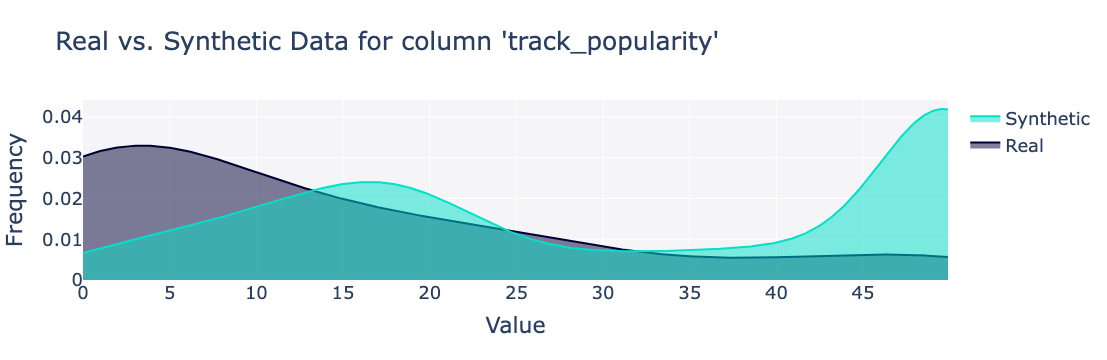

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


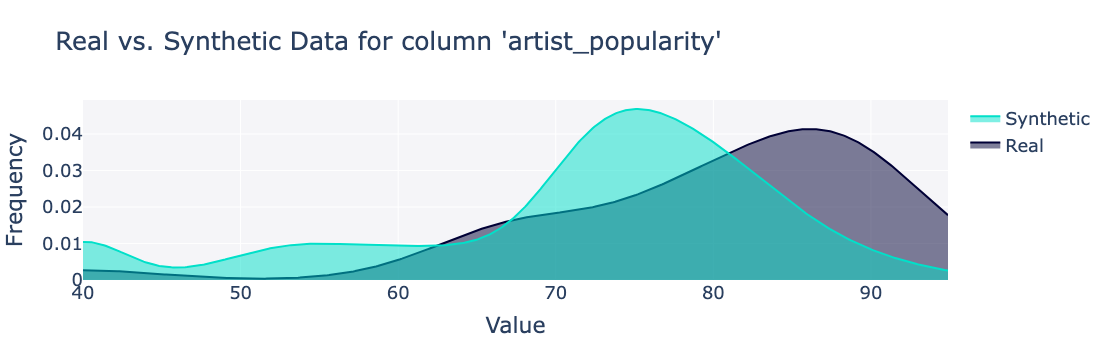

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


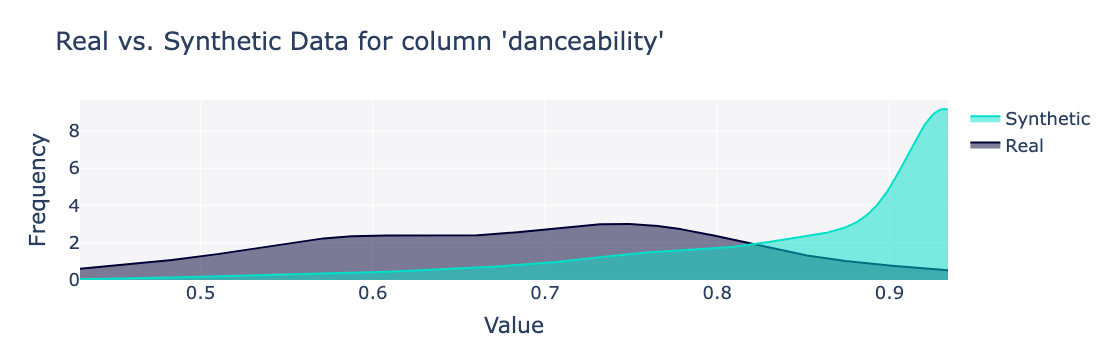

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


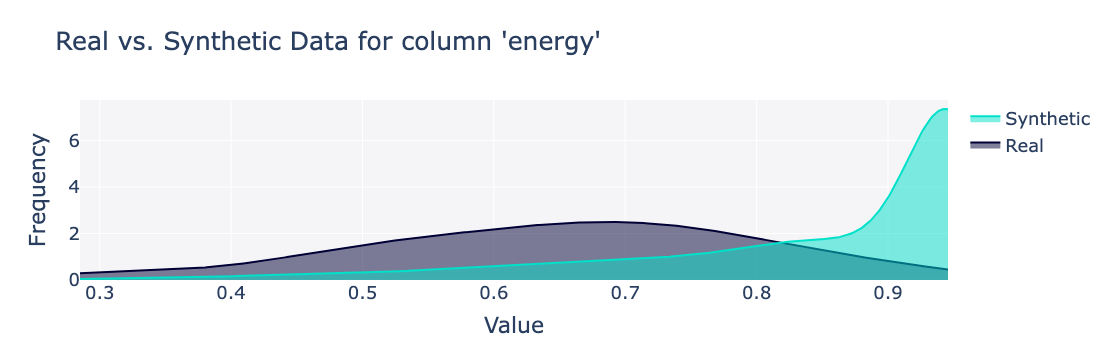

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


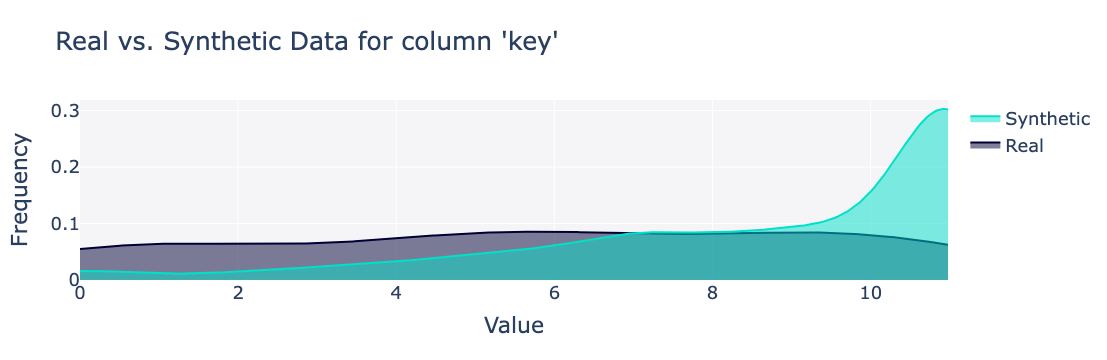

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


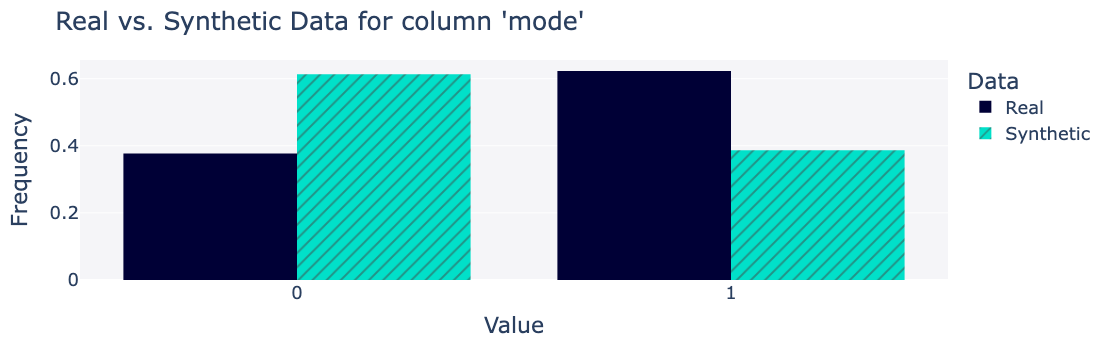

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


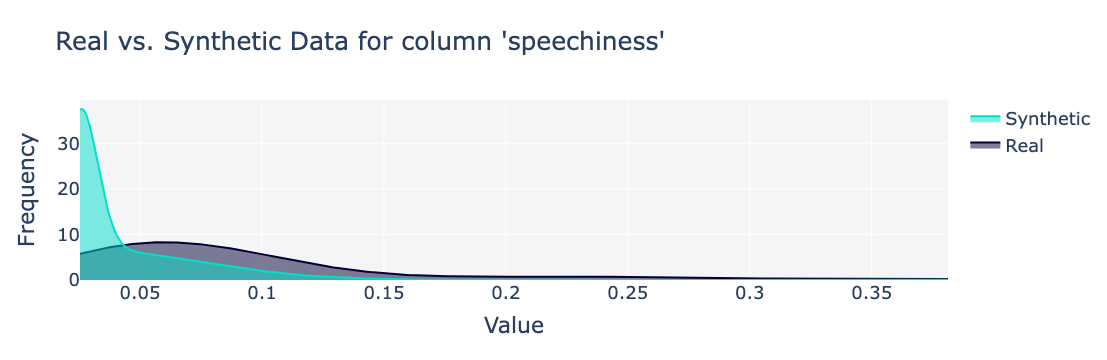

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


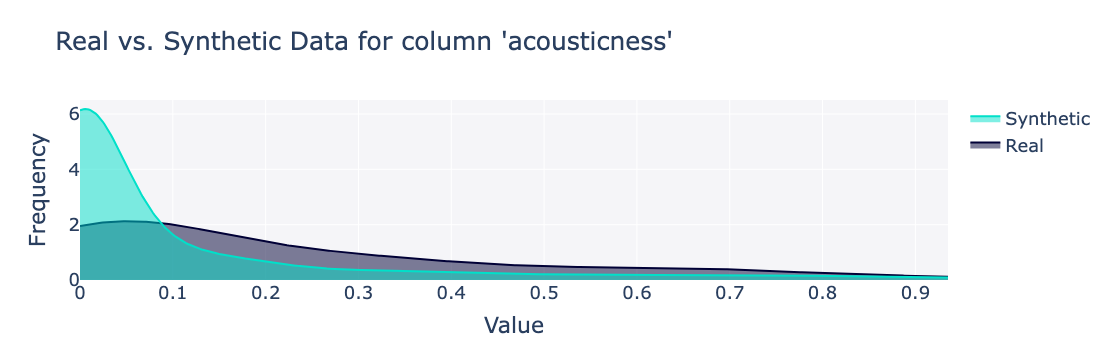

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


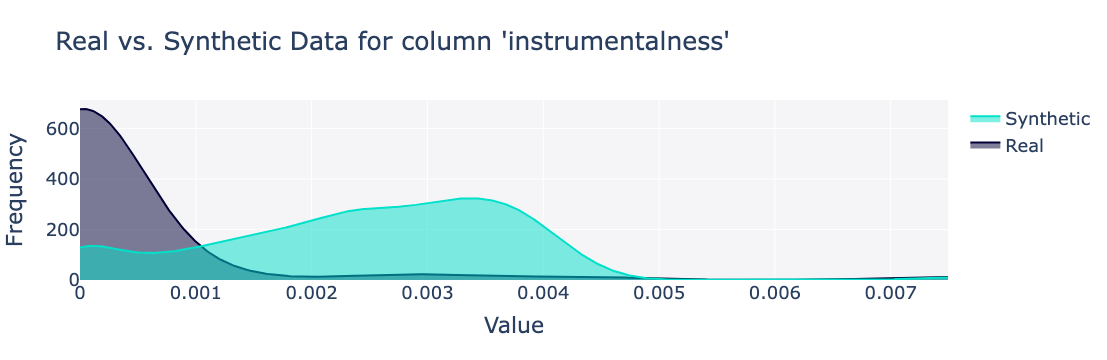

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


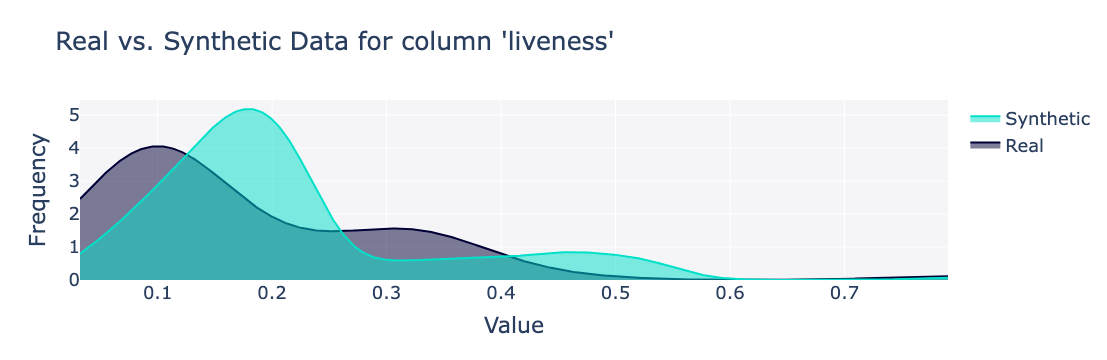

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


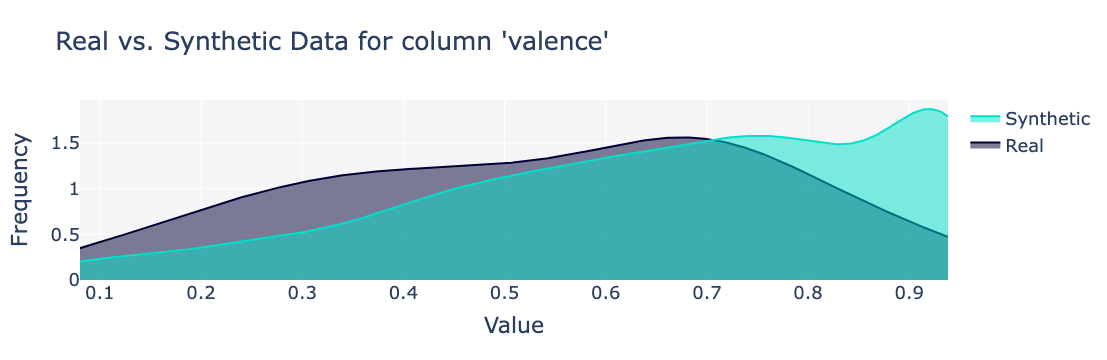

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


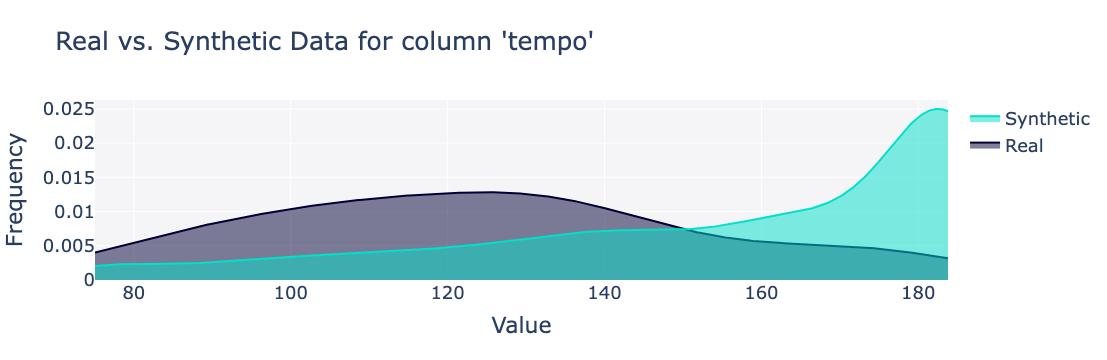

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


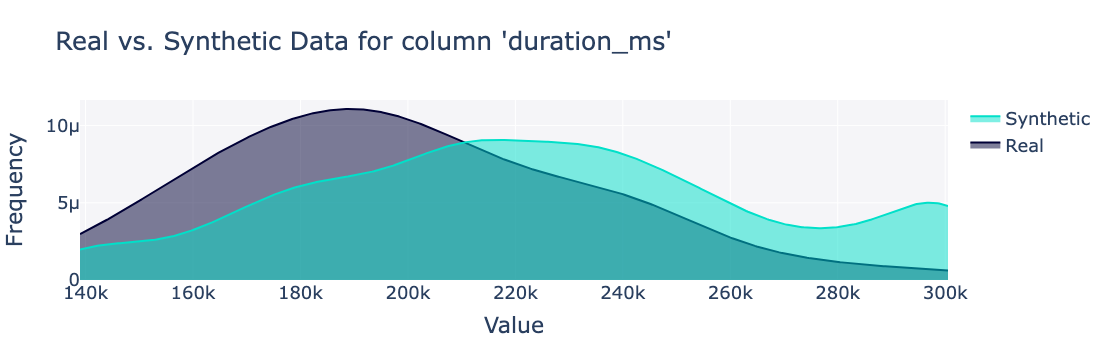

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [1064]:
for column_name in column_names:
    fig = plot_real_versus_synth_data(column_name ,unpopular_songs_augmented_df, CTGANSynth_data_df, metadata )
    fig.show()
    print('+' * 100)

In [1065]:
from sdv.single_table import TVAESynthesizer

# Create a synthesizer model
synthesizer_TVAESynth = TVAESynthesizer(metadata)

# Fit the synthesizer to the real data
synthesizer_TVAESynth.fit(unpopular_songs_augmented_df)

# Generate synthetic data (e.g., 1000 samples)
synthetic_data_TVAESynth = synthesizer_TVAESynth.sample(2302 - 62)

In [1066]:
# Save or use the synthetic data
synthetic_data_TVAESynth.to_csv('./synthetic_TVAESynth_data.csv', index=False)

In [1067]:
TVAESynth_data_df = pd.read_csv('synthetic_TVAESynth_data.csv')

In [1068]:
for column_name in column_names:
    fig = plot_real_versus_synth_data(column_name ,unpopular_songs_augmented_df, TVAESynth_data_df, metadata )
    fig.show()
    print('+' * 100)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [1069]:
from sdv.single_table import CopulaGANSynthesizer

# Create a synthesizer model
synthesizer_CopulaGAN = CopulaGANSynthesizer(metadata)

# Fit the synthesizer to the real data
synthesizer_CopulaGAN.fit(unpopular_songs_augmented_df)

# Generate synthetic data (e.g., 1000 samples)
synthetic_CopulaGAN_data = synthesizer.sample(2302 - 62)

In [1070]:
# Save or use the synthetic data
synthetic_CopulaGAN_data.to_csv('./synthetic_CopulaGANS_data.csv', index=False)

In [1071]:
CopulaGAN_data_data_df = pd.read_csv('synthetic_CopulaGANS_data.csv')

In [1072]:
for column_name in column_names:
    fig = plot_real_versus_synth_data(column_name ,unpopular_songs_augmented_df, CopulaGAN_data_data_df, metadata )
    fig.show()
    print('+' * 100)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


## Summary: Comparison of synthetic versus real data for four synthetic data synthesizers
- These synthesizers are part of the SVD (Synthetic Data Vault) python package, developed at MIT.
>> (see Patki, Wedge and Veeramachaneni, "The Synthetic Data Vault", available in the github repo)
### SVD docs describe these as:
- GaussianCopula, a  "classic, statistical methods to train a model and generate synthetic data."
>> 'Gaussian' referes to gaussian distribution and 'copula' to a type of generative function
- CTGAN, a "GAN-based, deep learning methods to train a model and generate synthetic data".
>> 'GAN' stands for 'Generative adversarial network'
- TVAE, "a variational autoencoder (VAE)-based, neural network techniques to train a model and generate synthetic data".
>> 'TVAE' stands for 'Triplet-Based Variational Autoencoder'
- CopulaGAN, "uses a mix classic, statistical methods and GAN-based deep learning methods to train a model and generate synthetic data."


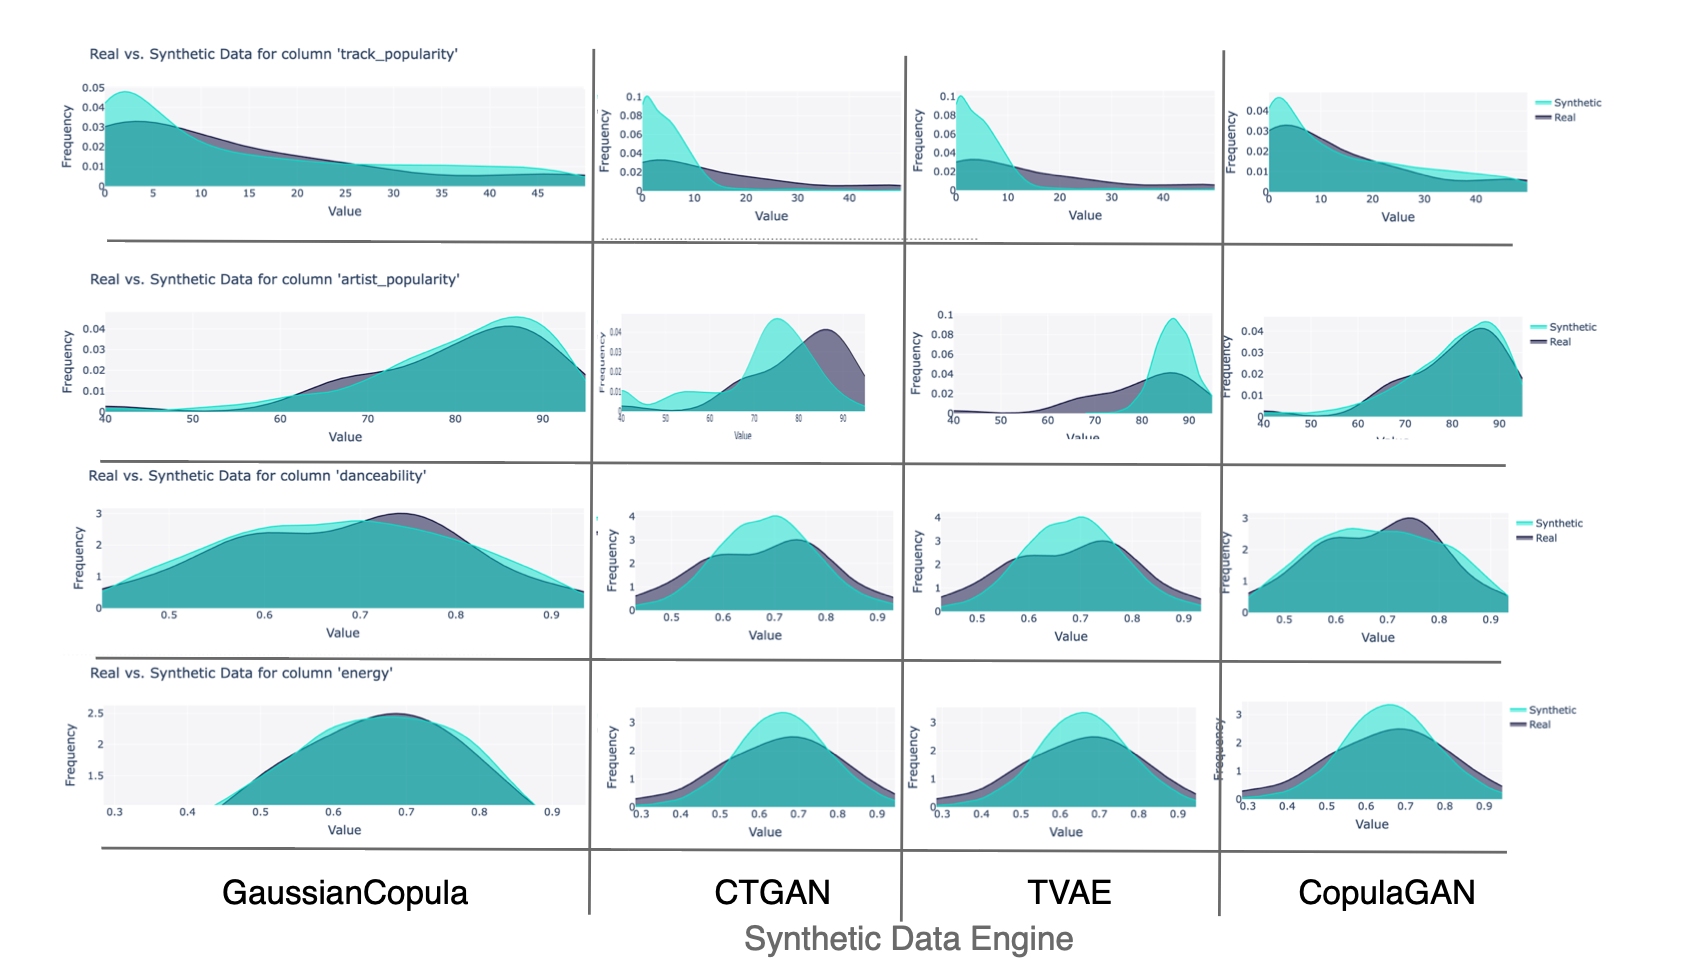

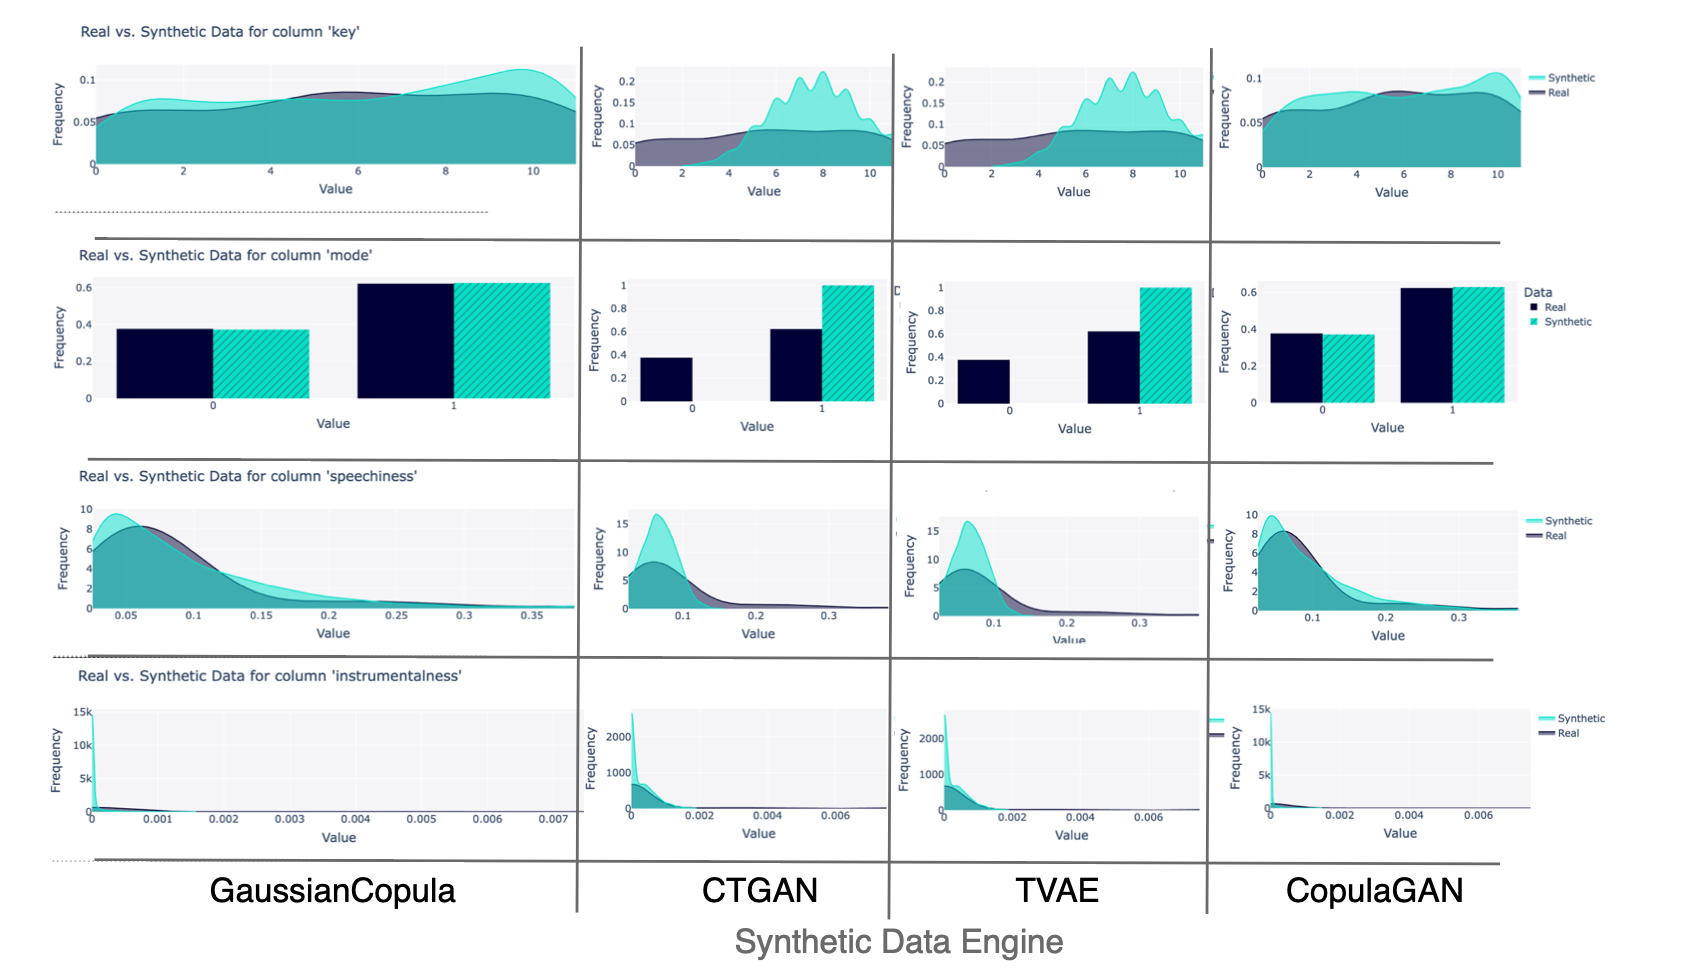

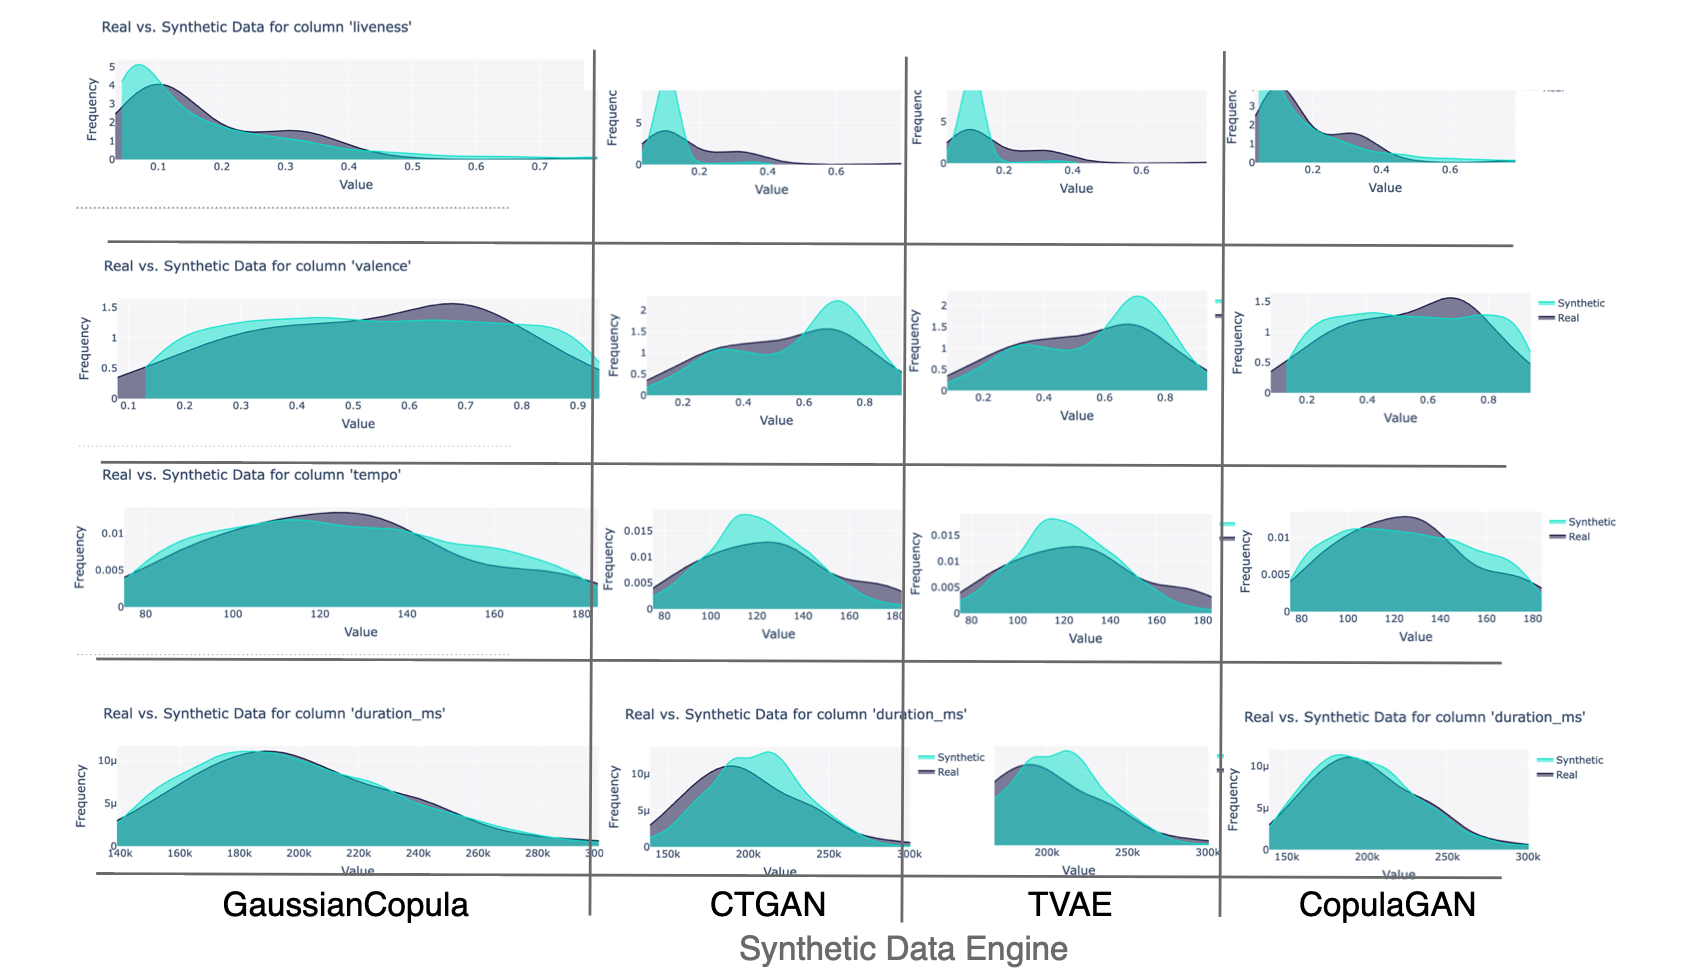

### From inspection, the GaussianCopula synthesizer appears to create synthetic data that is statistically most simlilar to the real data

In [1116]:
dataframes_to_edit_for_merge = [unpopular_songs_df,songs_with_genres_df]

In [1117]:
unpopular_songs_augmented_df.columns

Index(['track_popularity', 'artist_popularity', 'danceability', 'energy',
       'key', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature',
       'transformed_loudness', 'pop', 'rap', 'dance pop', 'pop rap',
       'modern rock', 'r&b', 'urban contemporary', 'trap', 'southern hip hop',
       'hip hop', 'rock', 'hip pop', 'neo mellow', 'pop rock', 'pop dance',
       'dirty south rap', 'edm', 'atl hip hop', 'post-grunge',
       'alternative metal', 'post-teen pop', 'talent show', 'contemporary r&b',
       'permanent wave', 'gangster rap', 'indietronica', 'europop',
       'pov: indie', 'uk dance', 'alternative rock', 'nu metal',
       'urbano latino', 'neo soul', 'uk pop', 'girl group', 'reggaeton',
       'pop punk', 'modern alternative rock', 'trap latino', 'melodic rap',
       'crunk', 'metropopolis', 'electro house', 'indie rock',
       'east coast hip hop', 'electropop', 'eurodance', 'viral pop',


In [1118]:
songs_with_genres_df.columns

Index(['track_popularity', 'artist_popularity', 'danceability', 'energy',
       'key', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature',
       'transformed_loudness', 'pop', 'rap', 'dance pop', 'pop rap',
       'modern rock', 'r&b', 'urban contemporary', 'trap', 'southern hip hop',
       'hip hop', 'rock', 'hip pop', 'neo mellow', 'pop rock', 'pop dance',
       'dirty south rap', 'edm', 'atl hip hop', 'post-grunge',
       'alternative metal', 'post-teen pop', 'talent show', 'contemporary r&b',
       'permanent wave', 'gangster rap', 'indietronica', 'europop',
       'pov: indie', 'uk dance', 'alternative rock', 'nu metal',
       'urbano latino', 'neo soul', 'uk pop', 'girl group', 'reggaeton',
       'pop punk', 'modern alternative rock', 'trap latino', 'melodic rap',
       'crunk', 'metropopolis', 'electro house', 'indie rock',
       'east coast hip hop', 'electropop', 'eurodance', 'viral pop',


In [1126]:
unpopular_songs_augmented_edit_df = unpopular_songs_augmented_df[['track_popularity', 'artist_popularity', 'danceability', 'energy','key', 'mode', 'speechiness', 'acousticness', 'instrumentalness','liveness', 'valence', 'tempo', 'duration_ms', 'time_signature','transformed_loudness']]

In [1128]:
songs_with_genres_edit_df = songs_with_genres_df[['track_popularity', 'artist_popularity', 'danceability', 'energy','key', 'mode', 'speechiness', 'acousticness', 'instrumentalness','liveness', 'valence', 'tempo', 'duration_ms', 'time_signature','transformed_loudness']]

In [1138]:
unpopular_songs_edit_df.shape

(61, 15)

In [1140]:
songs_with_genres_edit_df.shape

(2302, 15)

In [1144]:
synthetic_GaussianCopula_data_df.columns

Index(['track_popularity', 'artist_popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'pop', 'rap', 'dance pop', 'pop rap', 'modern rock',
       'r&b', 'urban contemporary', 'trap', 'southern hip hop', 'hip hop',
       'rock', 'hip pop', 'neo mellow', 'pop rock', 'pop dance',
       'dirty south rap', 'edm', 'atl hip hop', 'post-grunge',
       'alternative metal', 'post-teen pop', 'talent show', 'contemporary r&b',
       'permanent wave', 'gangster rap', 'indietronica', 'europop',
       'pov: indie', 'uk dance', 'alternative rock', 'nu metal',
       'urbano latino', 'neo soul', 'uk pop', 'girl group', 'reggaeton',
       'pop punk', 'modern alternative rock', 'trap latino', 'melodic rap',
       'crunk', 'metropopolis', 'electro house', 'indie rock',
       'east coast hip hop', 'electropop', 'eurodance', 'viral pop',
       'cana

In [1142]:
synthetic_GaussianCopula_edit_data_df = synthetic_GaussianCopula_data_df[['track_popularity', 'artist_popularity', 'danceability', 'energy','key', 'mode', 'speechiness', 'acousticness', 'instrumentalness','liveness', 'valence', 'tempo', 'duration_ms', 'time_signature','transformed_loudness']]

KeyError: "['transformed_loudness'] not in index"

In [1130]:
dataframes_to_edit_for_merge = [songs_with_genres_edit_df,unpopular_songs_edit_df]

In [1132]:
synth_plus_real_data_edited_df = pd.concat(dataframes_to_edit_for_merge)

In [1134]:
synth_plus_real_data_edited_df.head()

track_popularity  artist_popularity  danceability  \
track_id                                                                    
1BxfuPKGuaTgP7aM0Bbdwr                96                100         0.552   
3rUGC1vUpkDG9CZFHMur1t                96                 85         0.750   
3vkCueOmm7xQDoJ17W1Pm3                94                 84         0.504   
4xhsWYTOGcal8zt0J161CU                93                 83         0.943   
5XeFesFbtLpXzIVDNQP22n                93                 86         0.464   

                        energy  key  mode  speechiness  acousticness  \
track_id                                                               
1BxfuPKGuaTgP7aM0Bbdwr   0.702  9.0     1       0.1570        0.1170   
3rUGC1vUpkDG9CZFHMur1t   0.733  6.0     0       0.0319        0.2560   
3vkCueOmm7xQDoJ17W1Pm3   0.308  9.0     1       0.0321        0.8680   
4xhsWYTOGcal8zt0J161CU   0.558  2.0     1       0.0568        0.0026   
5XeFesFbtLpXzIVDNQP22n   0.417  0.0     0       0.0256        0.1360   

                        instrumentalness  liveness  valence    tempo  \
track_id                                                               
1BxfuPKGuaTgP7aM0Bbdwr          0.000021    0.1050    0.564  169.994   
3rUGC1vUpkDG9CZFHMur1t          0.000000    0.1140    0.844  111.018   
3vkCueOmm7xQDoJ17W1Pm3          0.135000    0.1580    0.121  113.950   
4xhsWYTOGcal8zt0J161CU          0.000002    0.0937    0.606  104.983   
5XeFesFbtLpXzIVDNQP22n          0.022000    0.0974    0.479   67.528   

                        duration_ms  time_signature  transformed_loudness  
track_id                                                                   
1BxfuPKGuaTgP7aM0Bbdwr       178427               4                14.400  
3rUGC1vUpkDG9CZFHMur1t       131872               1                16.927  
3vkCueOmm7xQDoJ17W1Pm3       137773               4                 5.149  
4xhsWYTOGcal8zt0J161CU       138411               4                15.196  
5XeFesFbtLpXzIVDNQP22n       183956               4                10.762

In [1136]:
synth_plus_real_data_edited_df.shape

(2363, 15)